In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from autoencoder import *
from torch.optim import Adam
import json
from torchsummary import summary

In [2]:
def set_seed(seed: int):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch (CPU)
    torch.manual_seed(seed)
    
    # Set the seed for PyTorch (GPU), if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    
    # Ensure deterministic behavior in certain cases
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # This can be set to True for non-deterministic algorithms (faster on some hardware)


set_seed(42)

# Load in Data and Normalize

In [3]:
# changed after making LatentPARC folder

path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path
new_path = os.path.dirname(path)  # Remove the last folder

print(new_path)

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch


In [4]:
# Add the root directory (PARCTorch) to the system path
sys.path.append(new_path)
from data.normalization import compute_min_max

In [5]:
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = new_path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/LatentPARC/autoencoder
Total files to process: 134
Processed 100/134 files.
Processed 134/134 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [6]:
import os
import torch
from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path
future_steps = 3
# Path to the min_max.json file
min_max_path = os.path.join(new_path, "data", "hmx_min_max.json")  # Correct path
batch_size = 32
validation_split = 0.2  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

# Optionally, create DataLoader for test dataset
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-02-13 15:42:52,726 [INFO] Starting data validation...
2025-02-13 15:42:52,728 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 287.75it/s]
2025-02-13 15:42:53,081 [INFO] Data validation completed successfully.
2025-02-13 15:42:53,083 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 243.59it/s]
2025-02-13 15:42:53,497 [INFO] Total samples in dataset: 1200
2025-02-13 15:42:53,504 [INFO] Starting data validation...
2025-02-13 15:42:53,506 [INFO] Validating .npy files...
Validating files: 100%|██████████| 34/34 [00:00<00:00, 313.56it/s]
2025-02-13 15:42:53,618 [INFO] Data validation completed successfully.
2025-02-13 15:42:53,619 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 34/34 [00:00<00:00, 418.90it/s]
2025-02-13 15:42:53,705 [INFO] Total samples in dataset: 408


In [7]:
# data investigation for me

In [7]:
ic, t0, t1, target = train_dataset[0]  # Unpack the tuple
print(ic[:3, ...].shape)
print(target[0, :3, ...].shape)

print(ic.shape)
print(t0.shape)
print(t1.shape)
print(target.shape)

torch.Size([3, 128, 256])
torch.Size([3, 128, 256])
torch.Size([5, 128, 256])
torch.Size([])
torch.Size([3])
torch.Size([3, 5, 128, 256])


In [10]:
#Experimentation for full latent parc implementation

for images in tqdm(train_loader):
    # Zeroing gradients

    # Sending images to device
    # images = images[0][:, 0:3, ...]
    print(images[3].squeeze(0).shape)
    
    break
    
# So... target = images[-1] and get rid of the 0 channel

  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([32, 5, 128, 256])


# Viz to see if data was loaded properly

Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.7335823178291321
  Step 1: min=0.0, max=0.6764407157897949
  Step 2: min=0.0, max=0.6388058066368103
  Step 3: min=0.0, max=0.7466552257537842
Channel 1: IC min=0.016738668084144592, IC max=0.23623709380626678
  Step 1: min=0.016738668084144592, max=0.29549694061279297
  Step 2: min=0.016738668084144592, max=0.2108292430639267
  Step 3: min=0.016738668084144592, max=0.19169242680072784
Channel 2: IC min=1.0, IC max=1.0
  Step 1: min=1.0, max=1.0
  Step 2: min=1.0, max=1.0
  Step 3: min=1.0, max=1.0
Channel 3: IC min=0.2107905149459839, IC max=0.5110159516334534
  Step 1: min=0.21734386682510376, max=0.45576831698417664
  Step 2: min=0.19985902309417725, max=0.42335331439971924
  Step 3: min=0.21734386682510376, max=0.44784533977508545
Channel 4: IC min=0.4114098846912384, IC max=0.6650390028953552
  Step 1: min=0.41520553827285767, max=0.6084203720092773
  Step 2: min=0.42265036702156067, max=0.5798934698104858
  Step 3: min=0.43

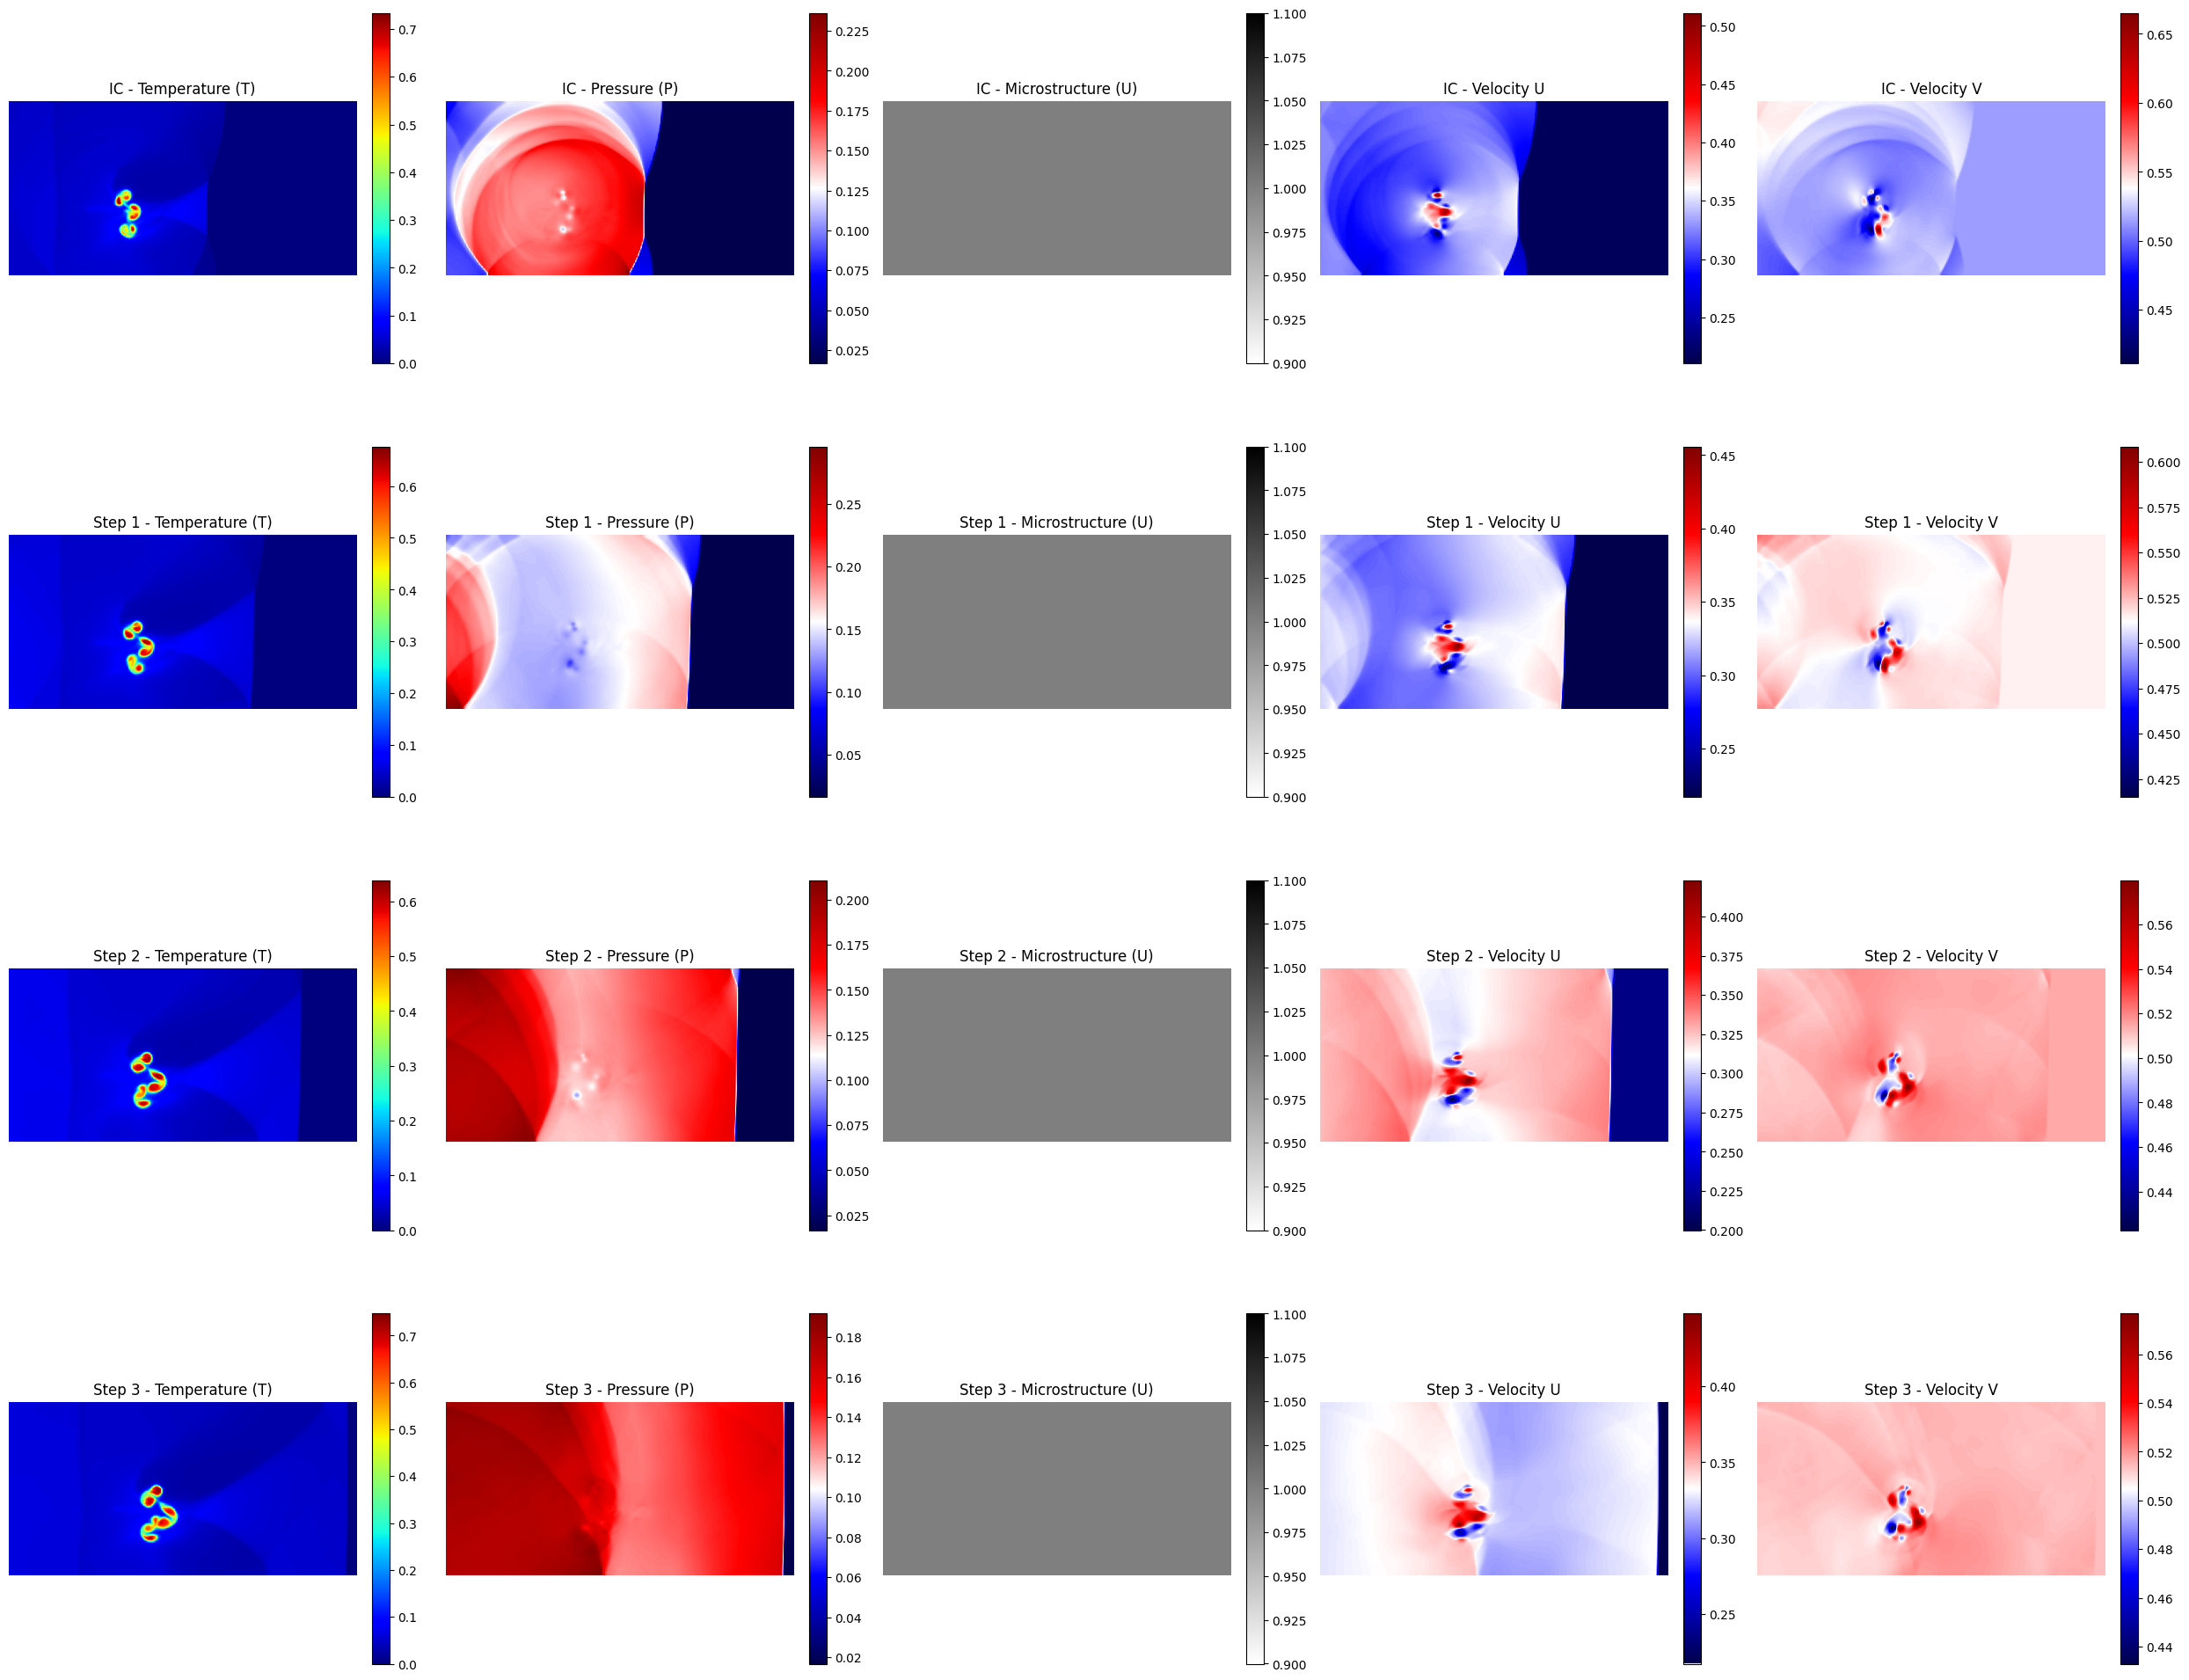

In [8]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = [
        "Temperature (T)",
        "Pressure (P)",
        "Microstructure (U)",
        "Velocity U",
        "Velocity V",
    ]
    custom_cmaps = ["jet", "seismic", "binary", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

# Define Autoencoder Architecture + Training

In [47]:
class LpLoss(torch.nn.Module):
    def __init__(self, p=10):
        super(LpLoss, self).__init__()
        self.p = p

    def forward(self, input, target):
        # Compute element-wise absolute difference
        diff = torch.abs(input - target)
        # Summing over all dimensions except the batch dimension
        norm = torch.sum(diff**self.p, dim=tuple(range(1, diff.ndim)))**(1/self.p)
        return torch.mean(norm)  # Compute batch mean


In [19]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/LatentPARC/autoencoder"
weights_name="test"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8]
latent_dim = 16
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

#Loss Function
# criterion = torch.nn.L1Loss().cuda()
criterion = LpLoss(p=10).cuda()

# criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

#  training model
model = ConvolutionalAutoencoder(autoencoder, optimizer, save_path, weights_name)

log_dict = model.train(criterion, epochs=5, image_size = [128, 256], n_channels=3, device=device,
                        train_loader=train_loader, val_loader=val_loader, scheduler=scheduler, noise_fn=add_random_noise, initial_max_noise=0.16, reduce_on=3)

Epoch 1/5
Training...


100%|██████████| 35/35 [00:02<00:00, 11.96it/s]


Validating...


100%|██████████| 9/9 [00:00<00:00,  9.79it/s]


Epoch 1: Training Loss: 1.4303 Validation Loss: 1.1094
Epoch 2/5
Training...


100%|██████████| 35/35 [00:02<00:00, 12.34it/s]


Validating...


100%|██████████| 9/9 [00:00<00:00,  9.01it/s]


Epoch 2: Training Loss: 1.0458 Validation Loss: 1.0104
Epoch 3/5
Training...


100%|██████████| 35/35 [00:02<00:00, 12.75it/s]


Validating...


100%|██████████| 9/9 [00:00<00:00,  9.40it/s]


Epoch 3: Training Loss: 0.9781 Validation Loss: 0.9732
Epoch 4/5
Training...


100%|██████████| 35/35 [00:02<00:00, 12.18it/s]


Validating...


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Epoch 4: Training Loss: 0.9582 Validation Loss: 0.9568
Epoch 5/5
Training...


100%|██████████| 35/35 [00:02<00:00, 12.04it/s]


Validating...


100%|██████████| 9/9 [00:00<00:00,  9.42it/s]

Epoch 5: Training Loss: 0.9471 Validation Loss: 0.9492
Model weights saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/LatentPARC/autoencoder/test_5.pth


# Load in weights

In [48]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8]
latent_dim = 16
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

# Loss func
# criterion = torch.nn.L1Loss().cuda()
criterion = LpLoss(p=10).cuda()

# criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-5)

#  training model
model = ConvolutionalAutoencoder(autoencoder, optimizer)

In [49]:
# load weights into model
weights_path = "corrected_layers_3_8_latent_16_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_632310/1946356711.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
)

In [10]:
summary(encoder, (3, 128, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 64, 128]             224
              ReLU-2           [-1, 8, 64, 128]               0
            Conv2d-3           [-1, 16, 32, 64]           1,168
Total params: 1,392
Trainable params: 1,392
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.25
Params size (MB): 0.01
Estimated Total Size (MB): 1.63
----------------------------------------------------------------


# Make Predictions

In [50]:
n_channels = 3

for test_images in test_loader:
    # Sending test images to device
    test_images = test_images[0][:, 0:n_channels, ...].to(device)   # images in this case is T, P, mu fields
    with torch.no_grad():
        # Reconstructing test images
        reconstructed_imgs = model.network(test_images)
    # Sending reconstructed and original images to CPU for visualization
    reconstructed_imgs = reconstructed_imgs.cpu()
    test_images = test_images.cpu()

In [51]:
# Initialize lists to store all test images and reconstructed images
all_test_images = []
all_reconstructed_images = []

for test_images in test_loader:
    # Sending test images to device
    test_images = test_images[0][:, 0:n_channels, ...].to(device)   # images in this case is T, P, mu fields
    with torch.no_grad():
        # Reconstructing test images
        reconstructed_imgs = model.network(test_images)
    
    # Sending reconstructed and original images to CPU and accumulating in lists
    all_reconstructed_images.append(reconstructed_imgs.cpu())
    all_test_images.append(test_images.cpu())

# Concatenate all batches to create single tensors
all_test_images = torch.cat(all_test_images, dim=0)  # Shape: (total_images, n_channels, height, width)
all_reconstructed_images = torch.cat(all_reconstructed_images, dim=0)


In [52]:
all_test_images.shape, all_reconstructed_images.shape

(torch.Size([476, 3, 128, 256]), torch.Size([476, 3, 128, 256]))

# Visualizations

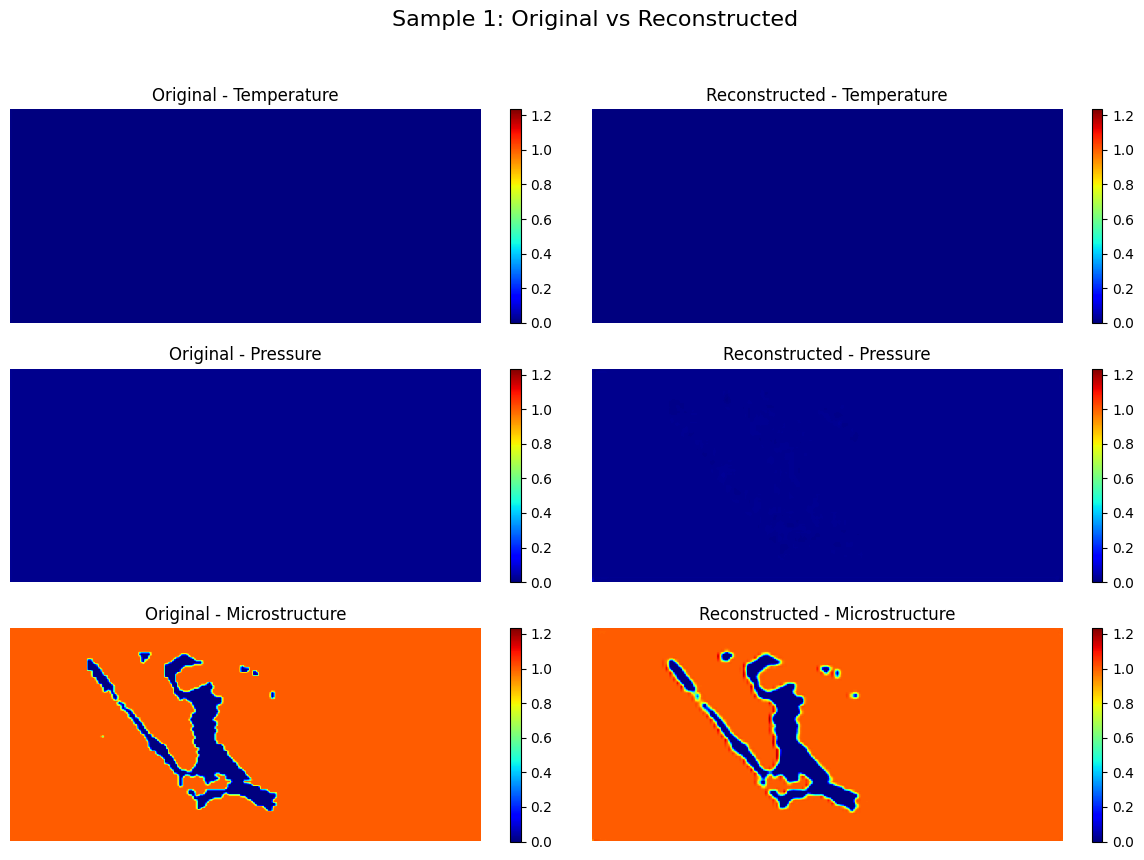

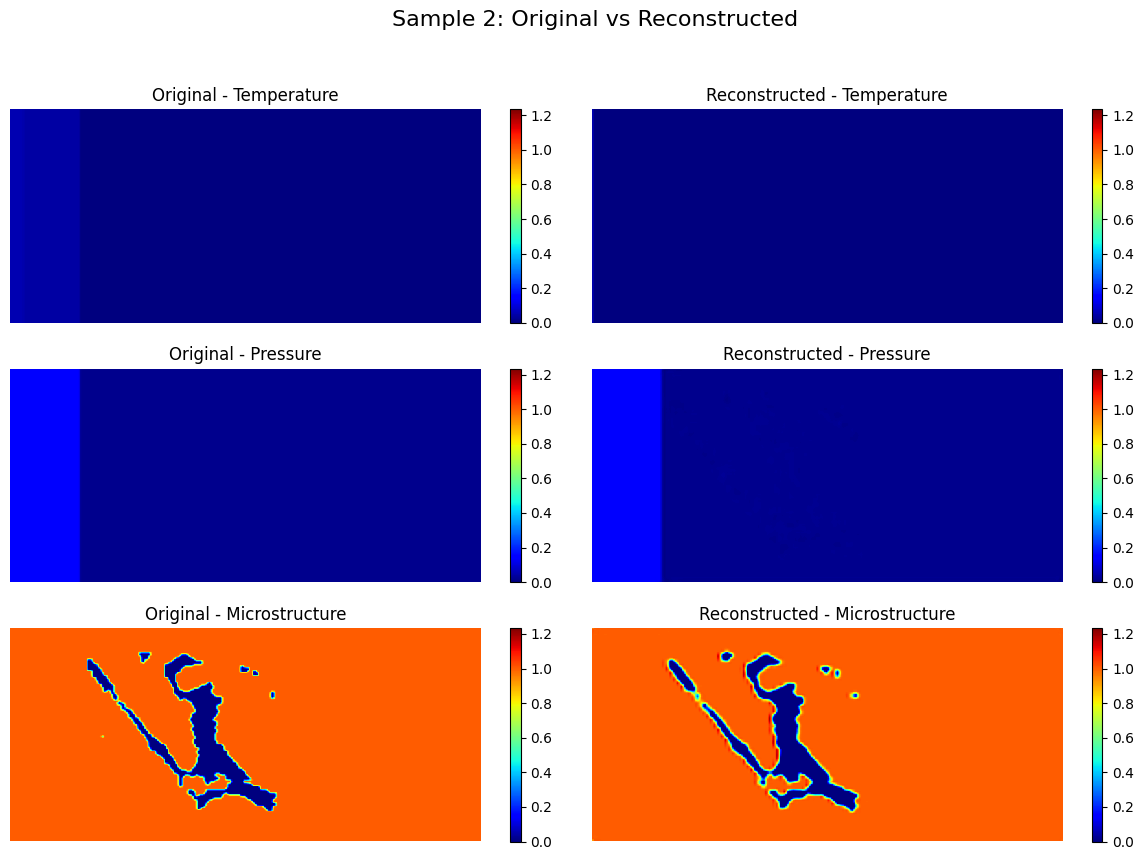

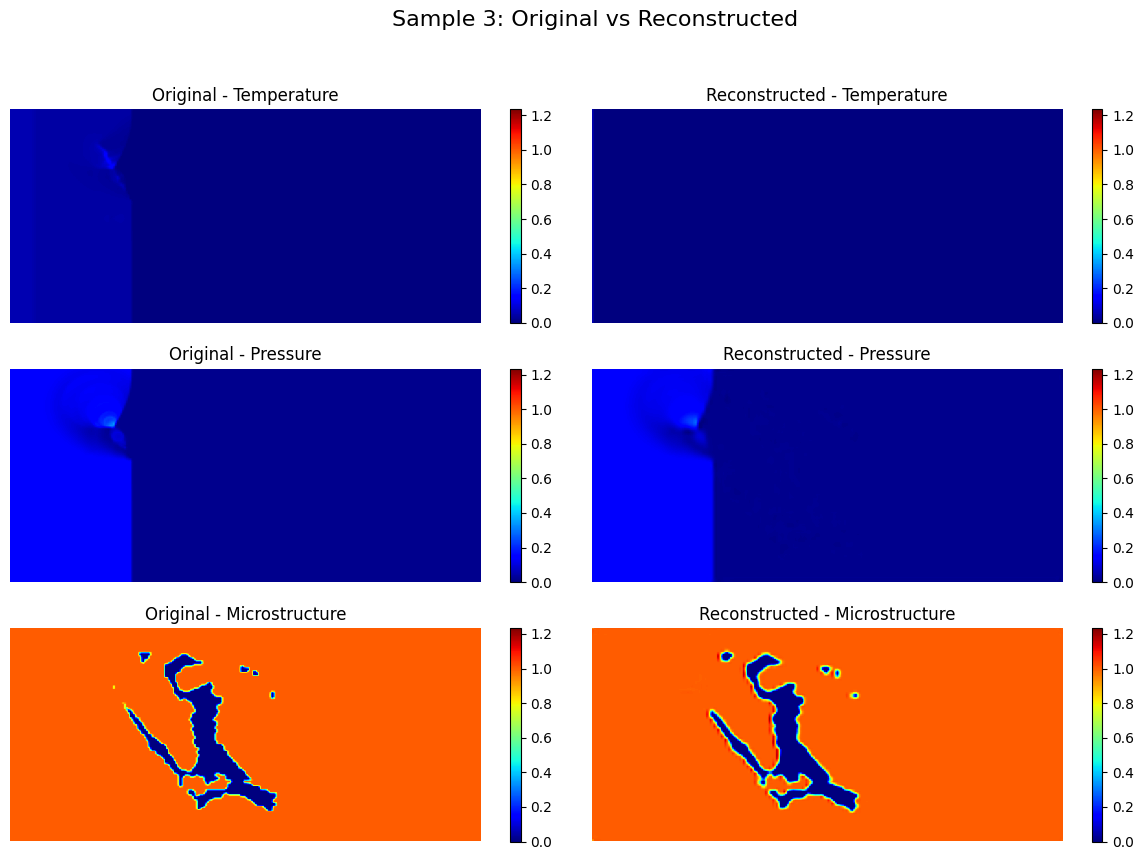

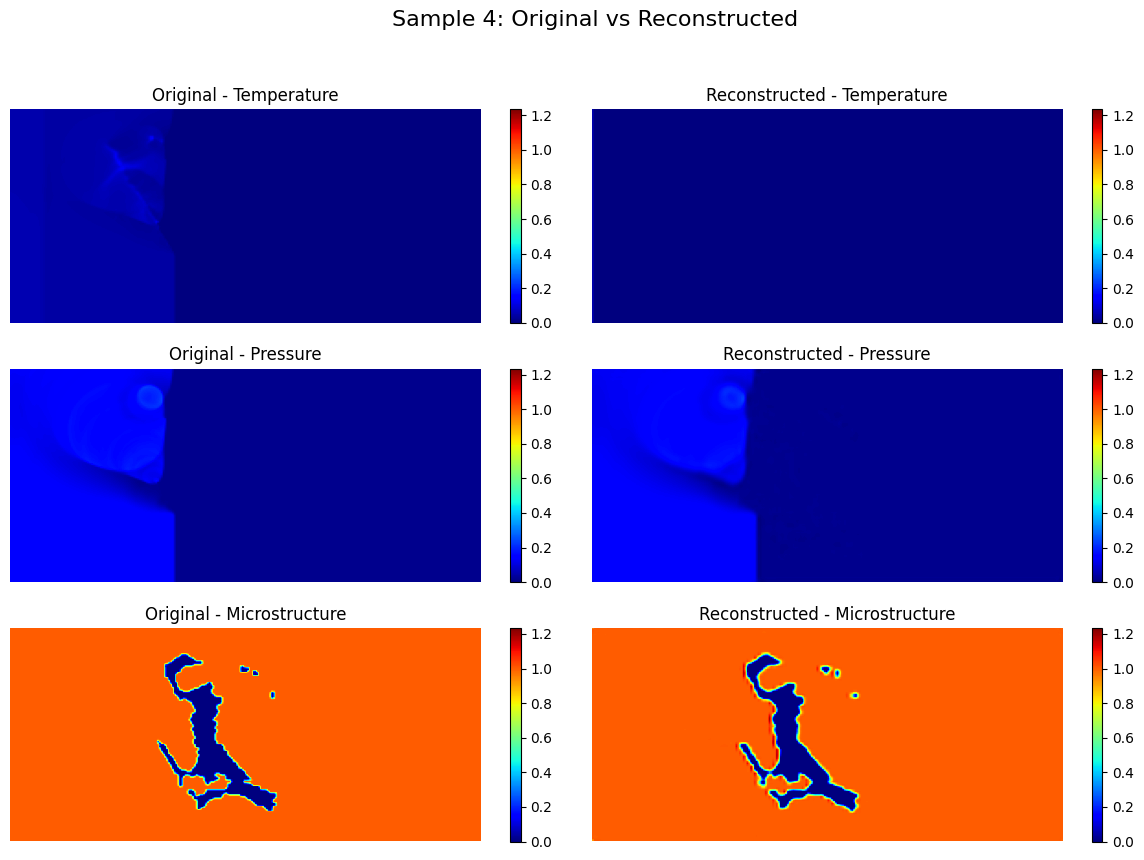

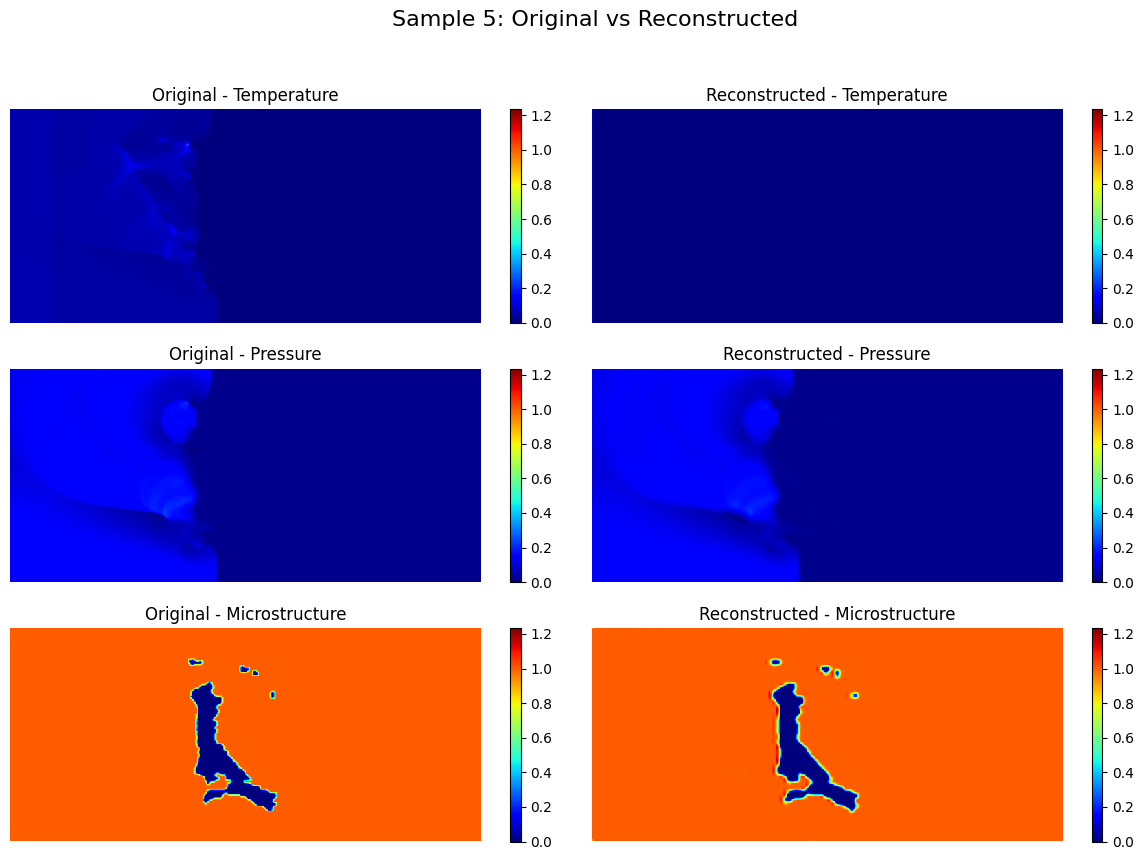

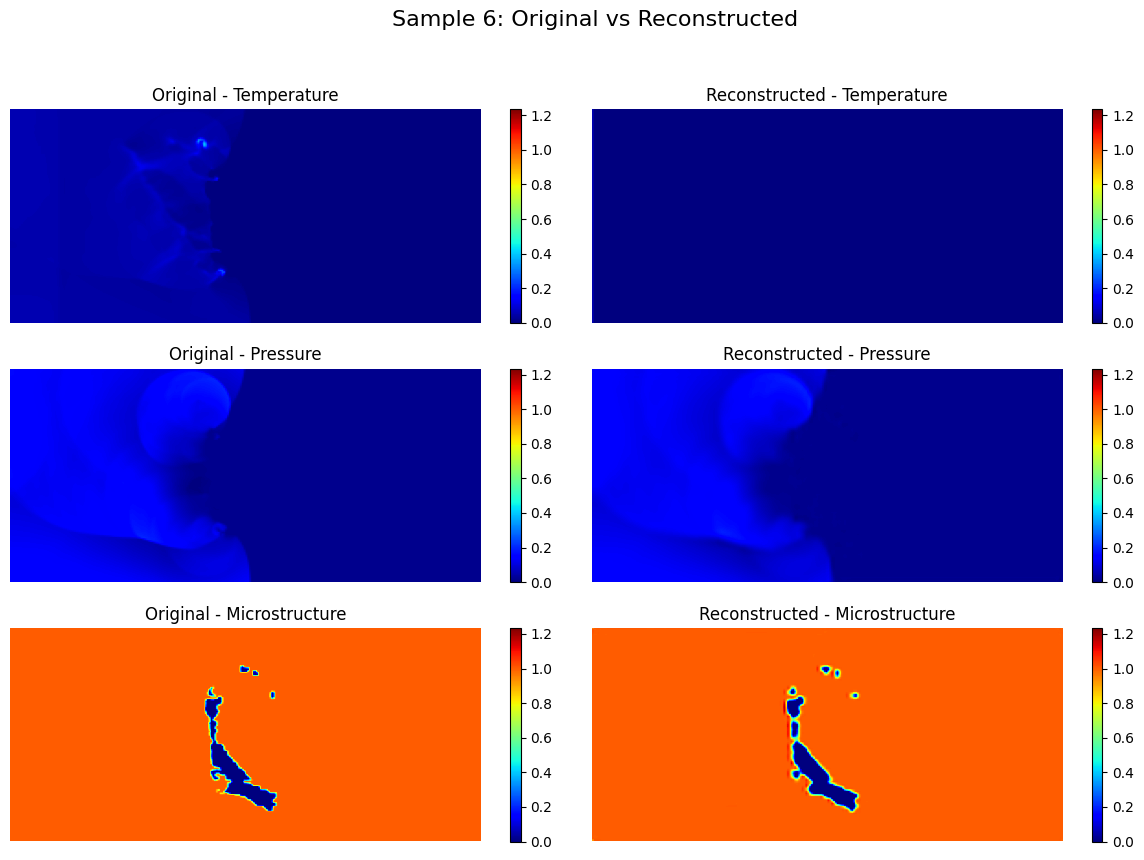

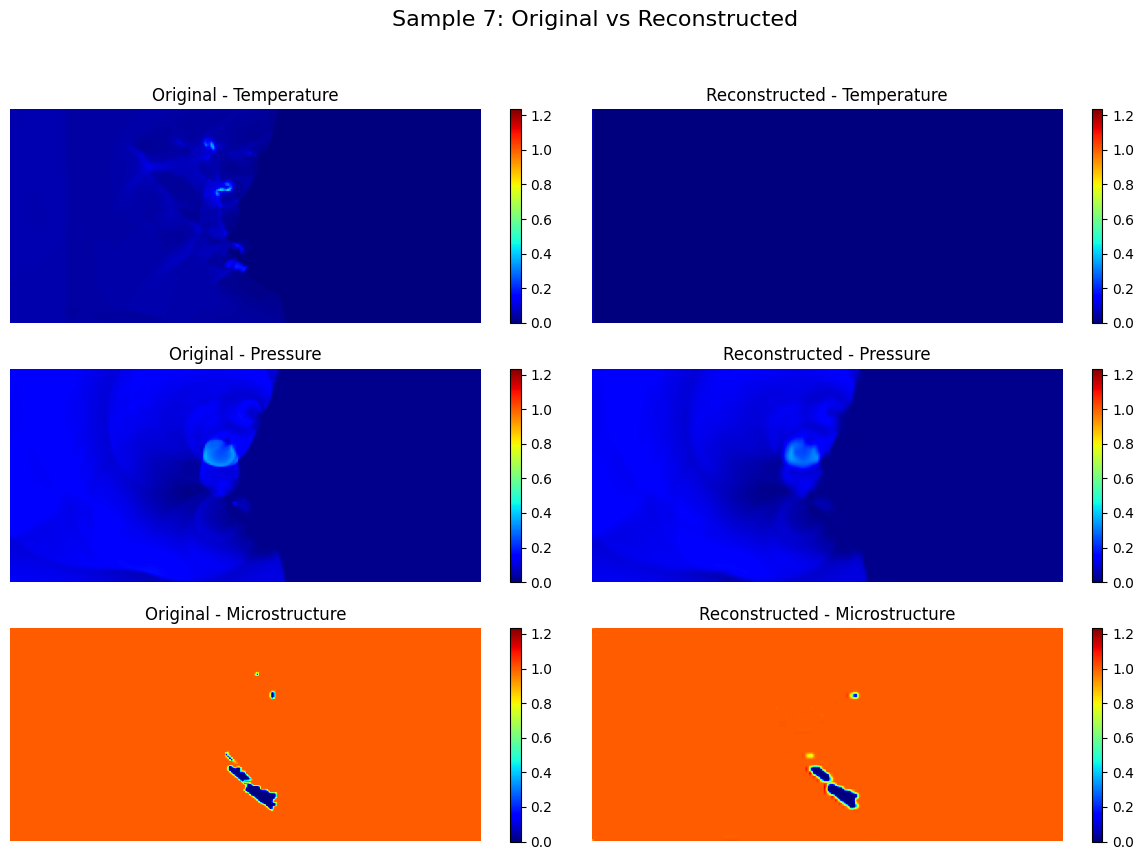

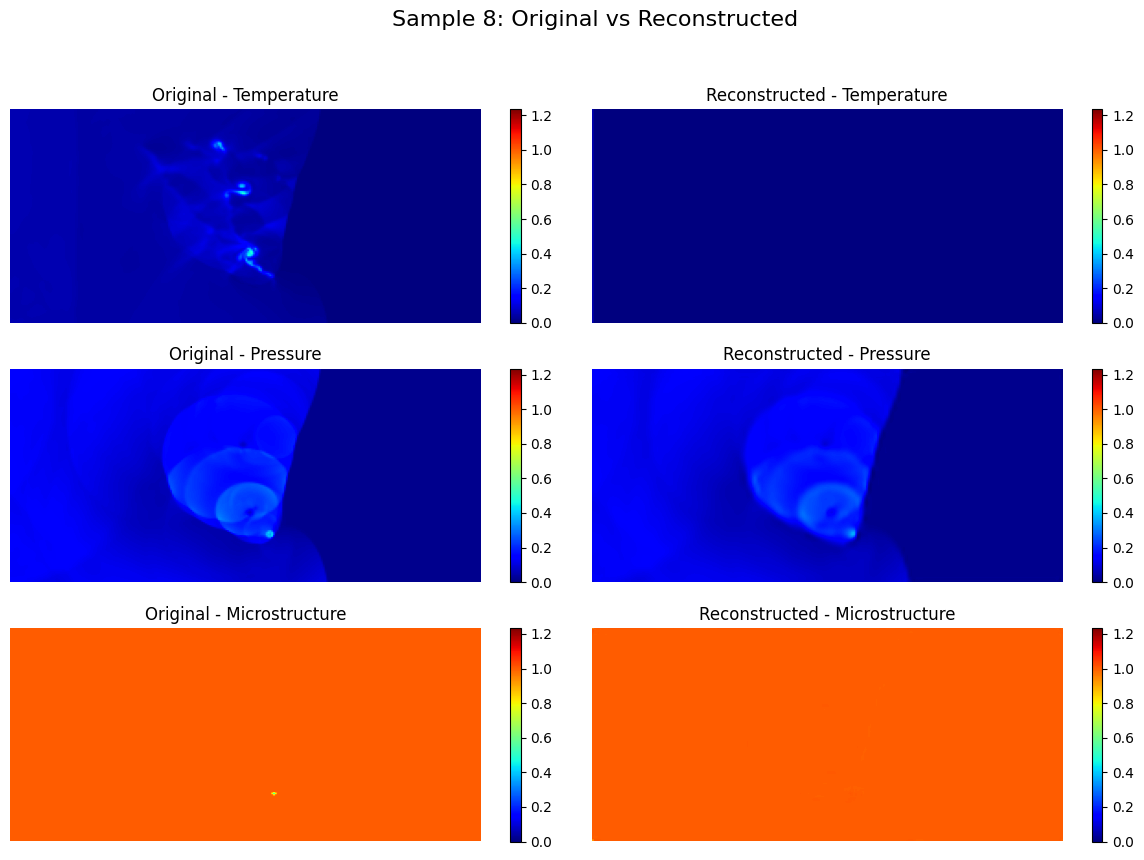

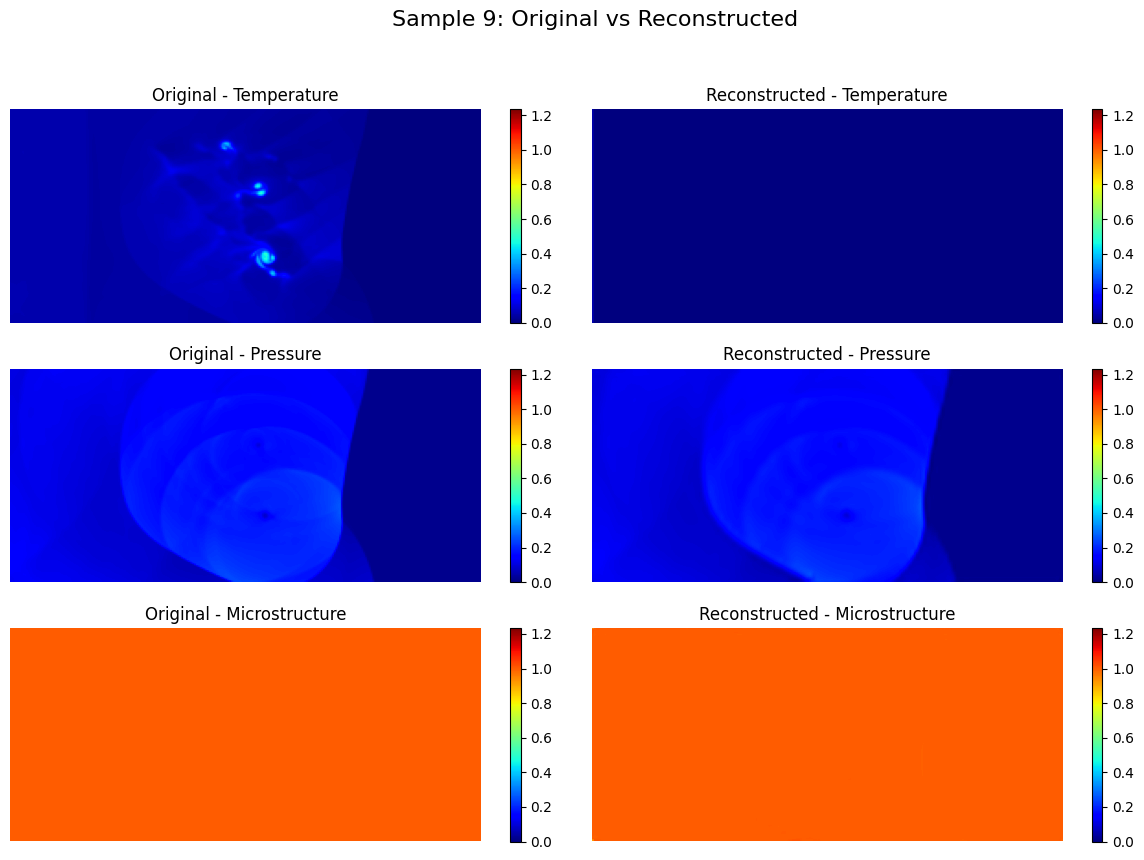

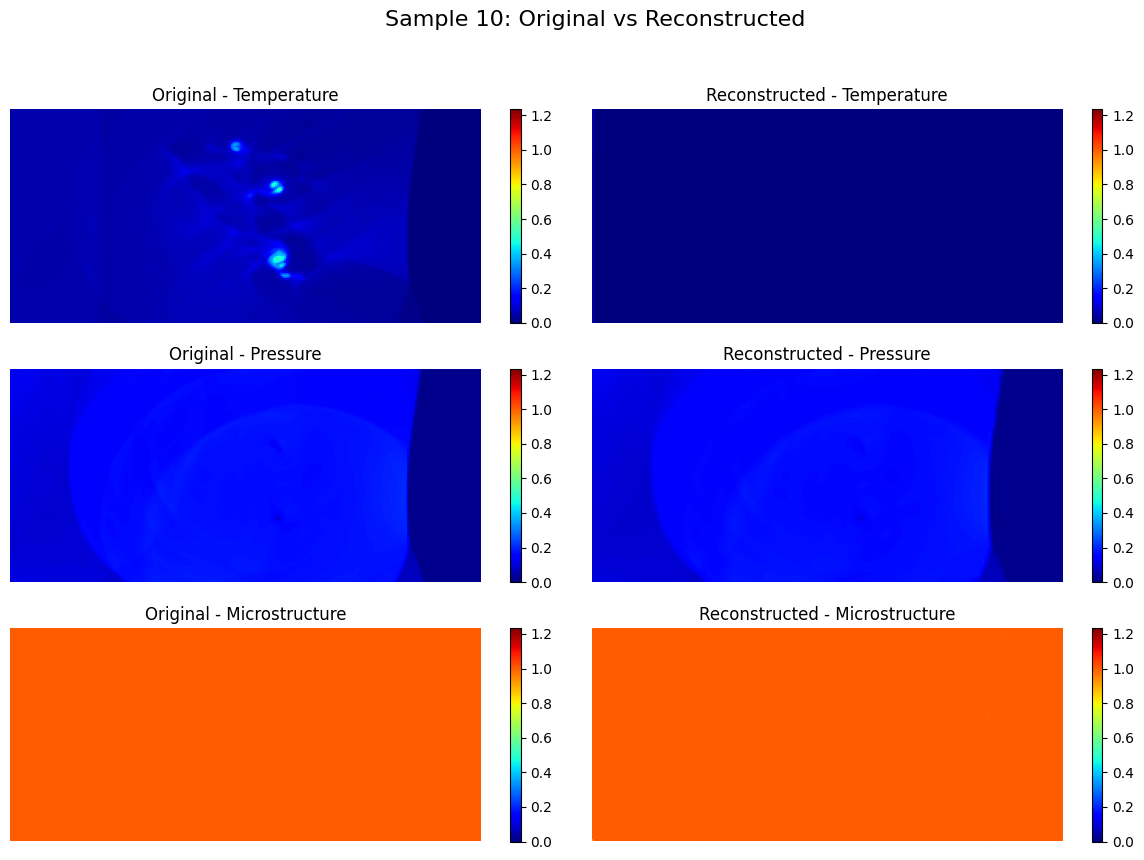

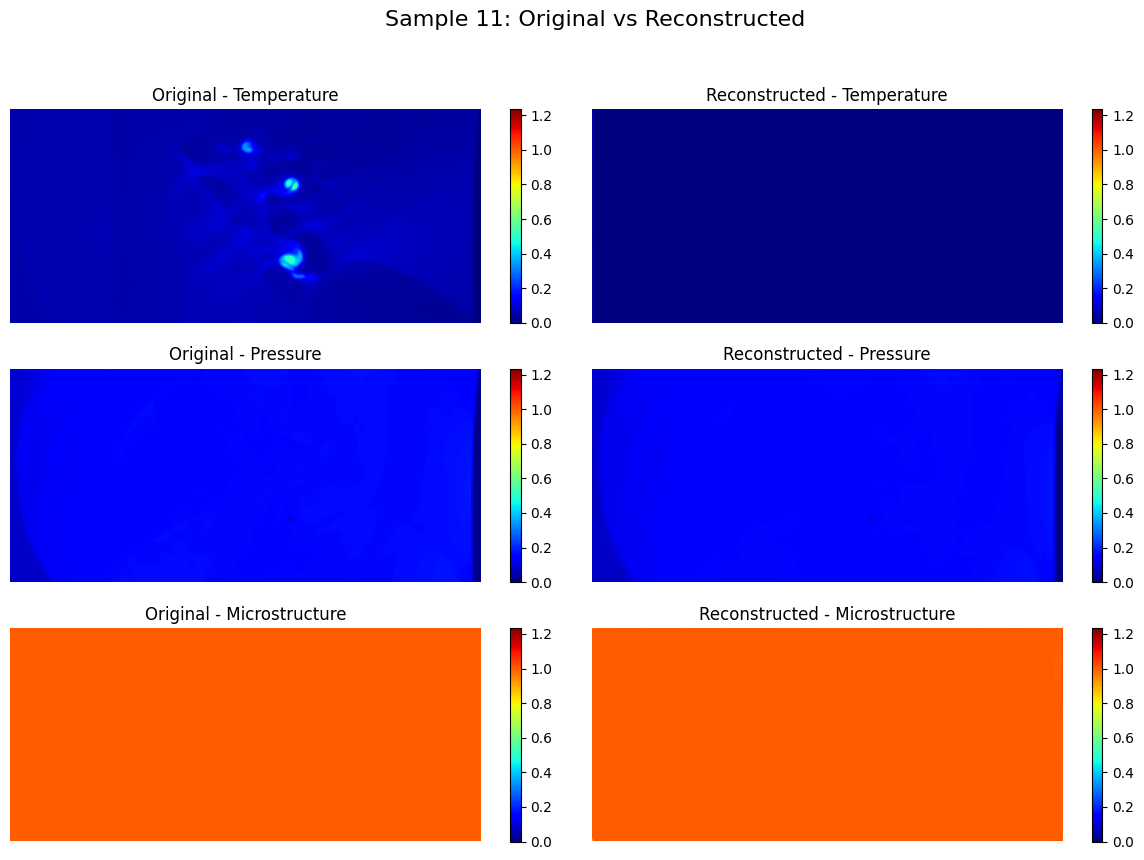

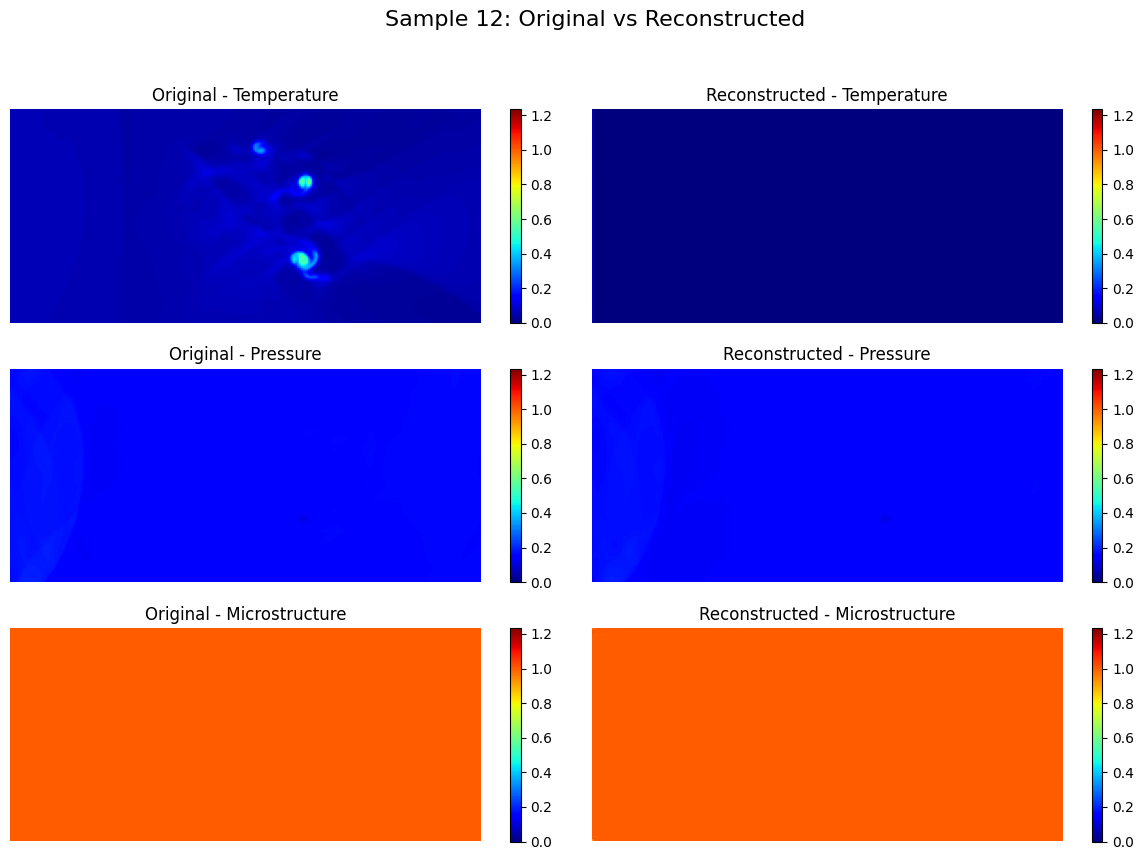

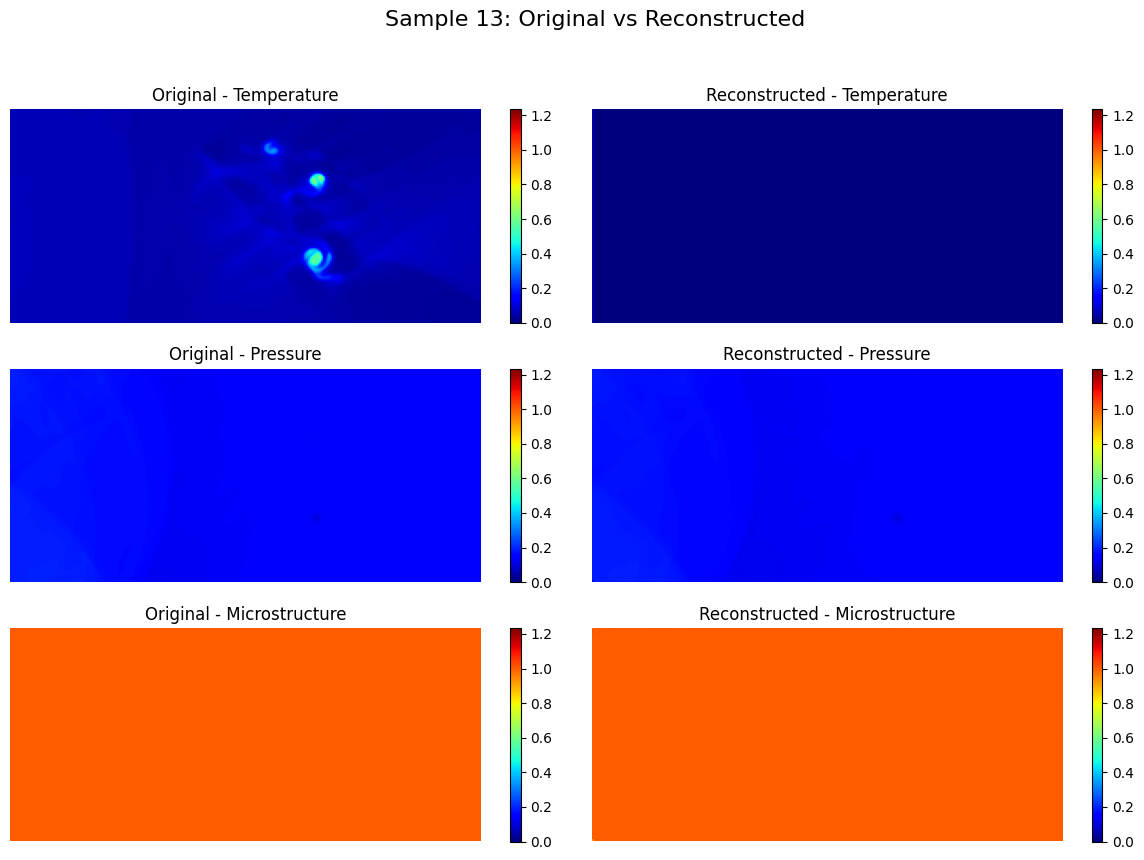

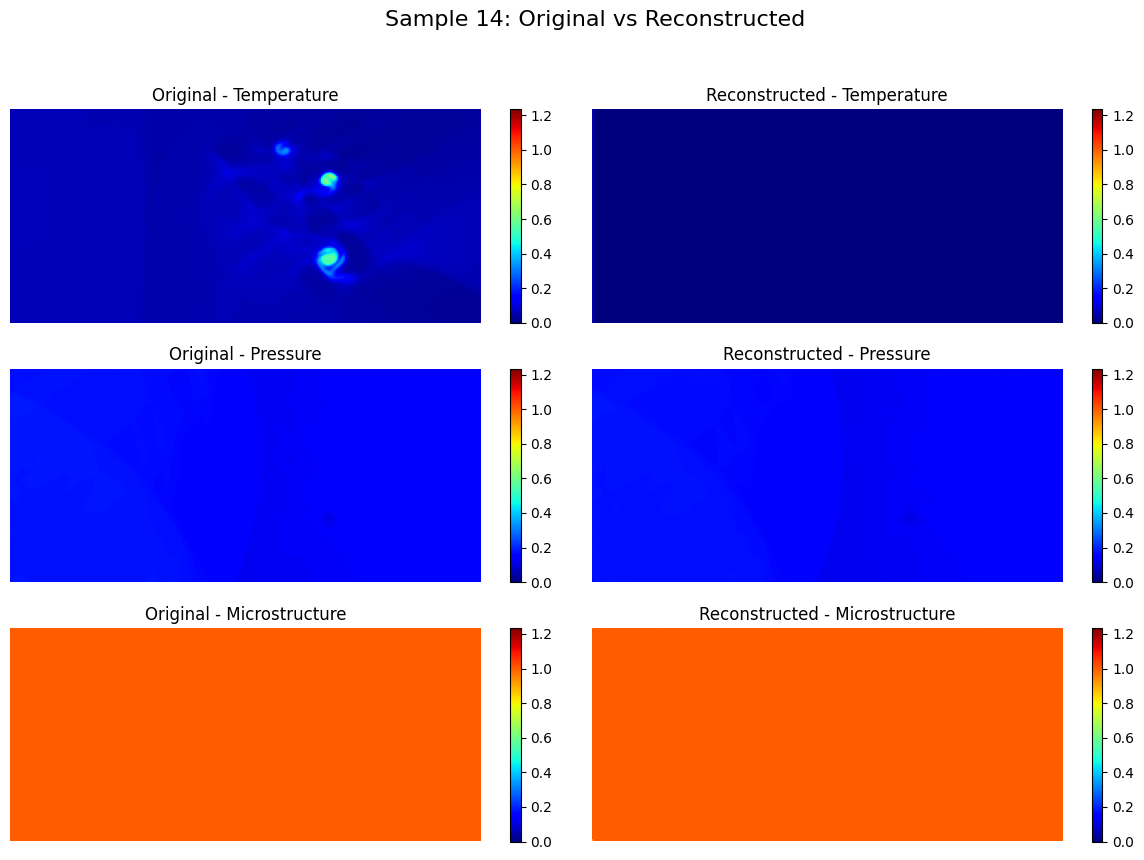

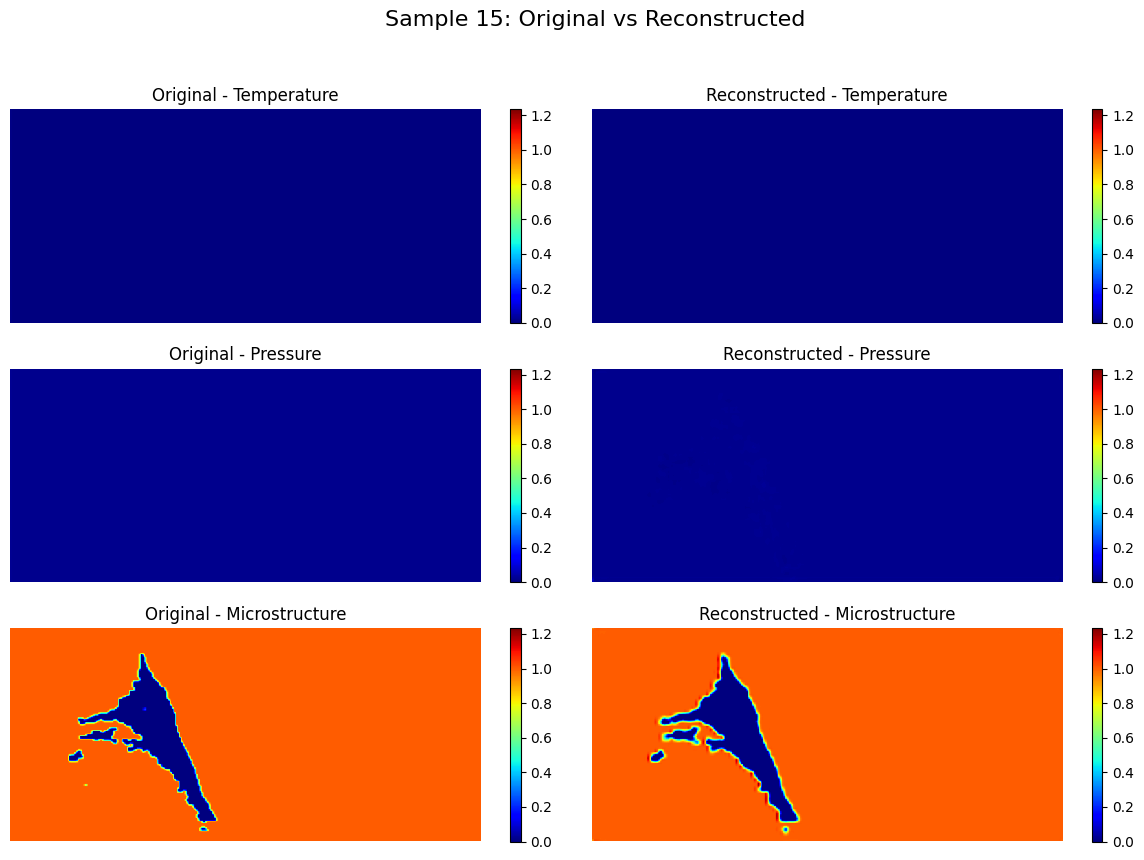

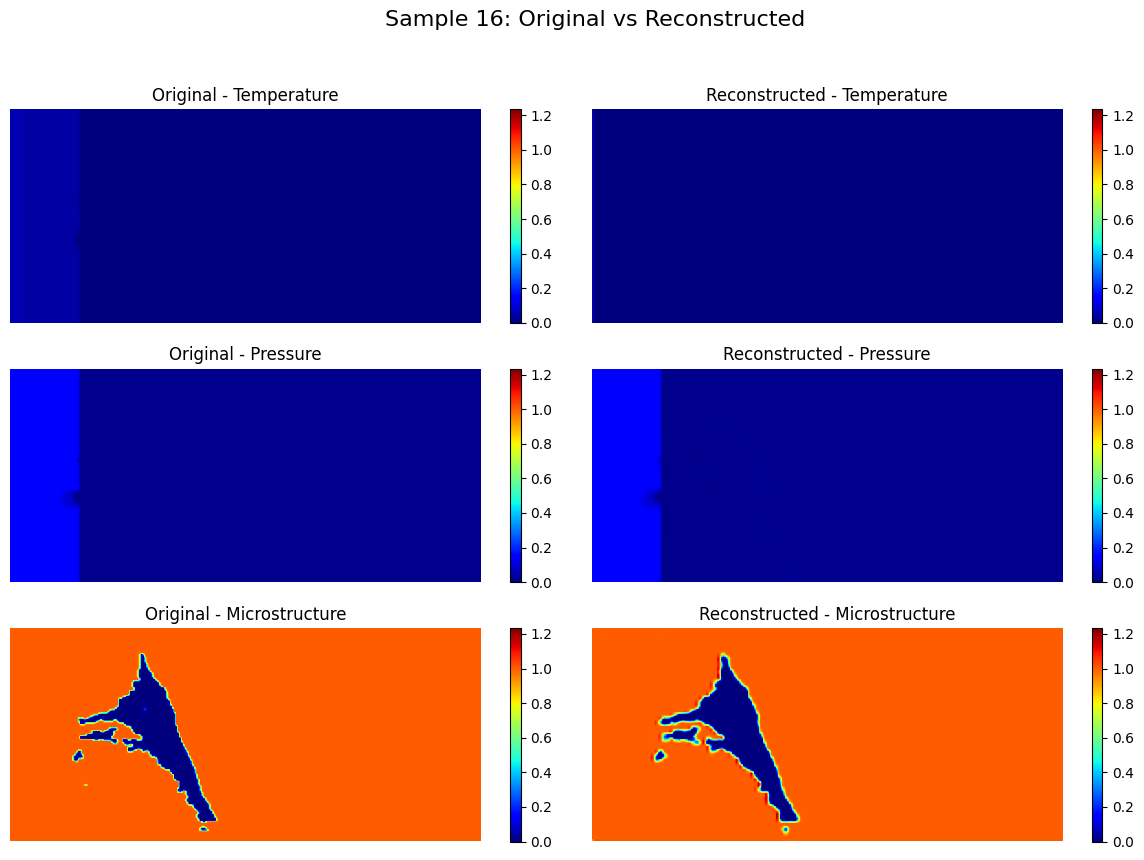

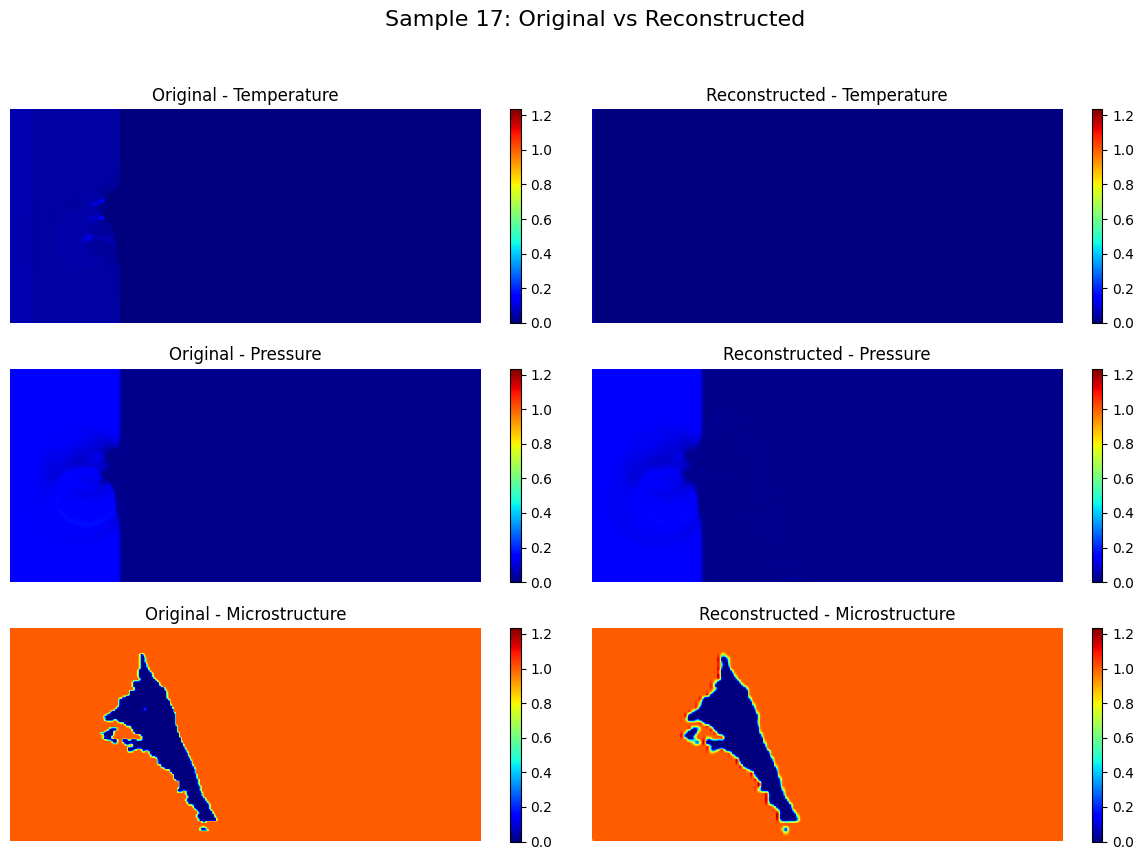

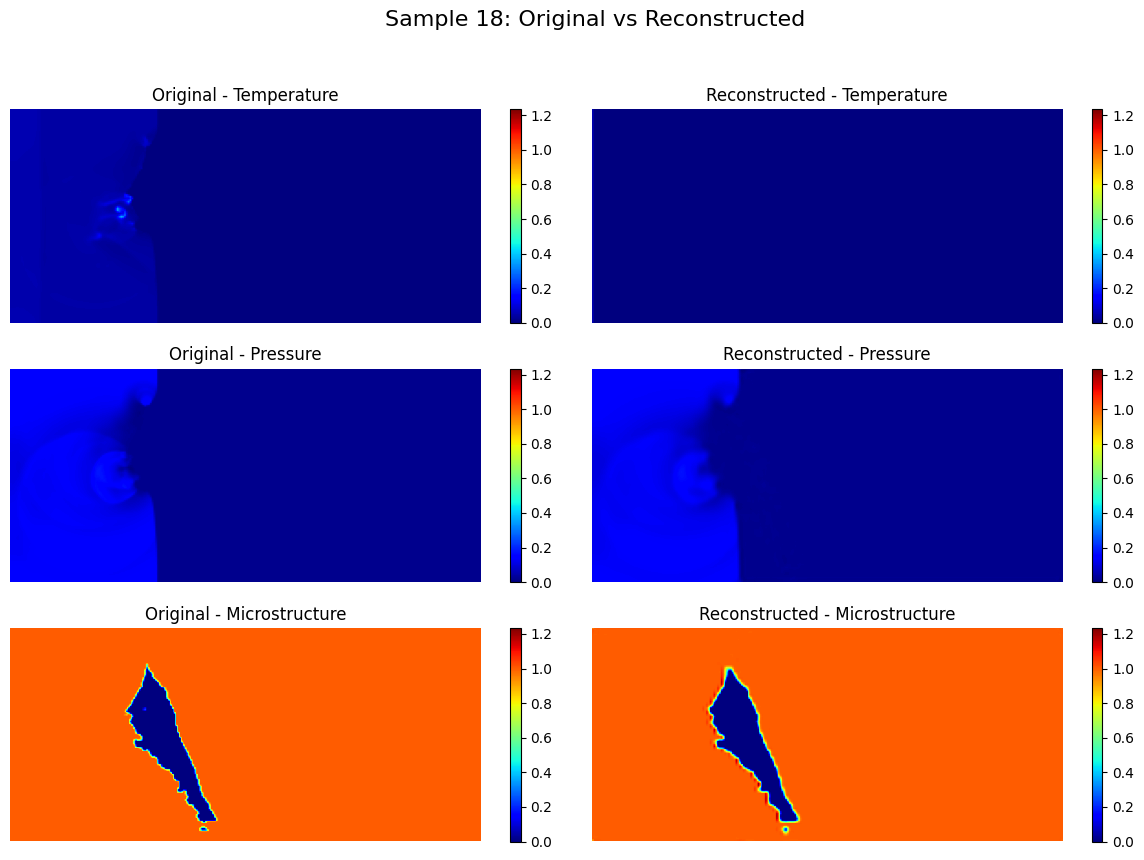

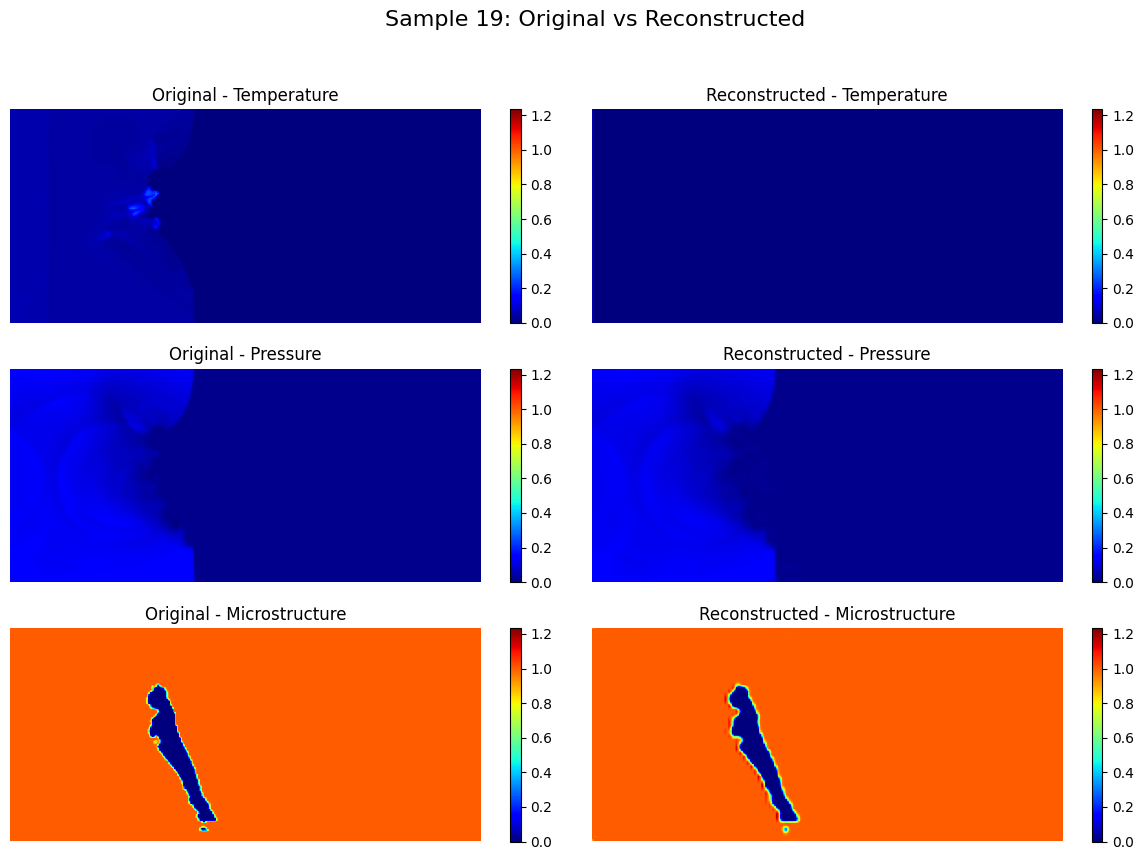

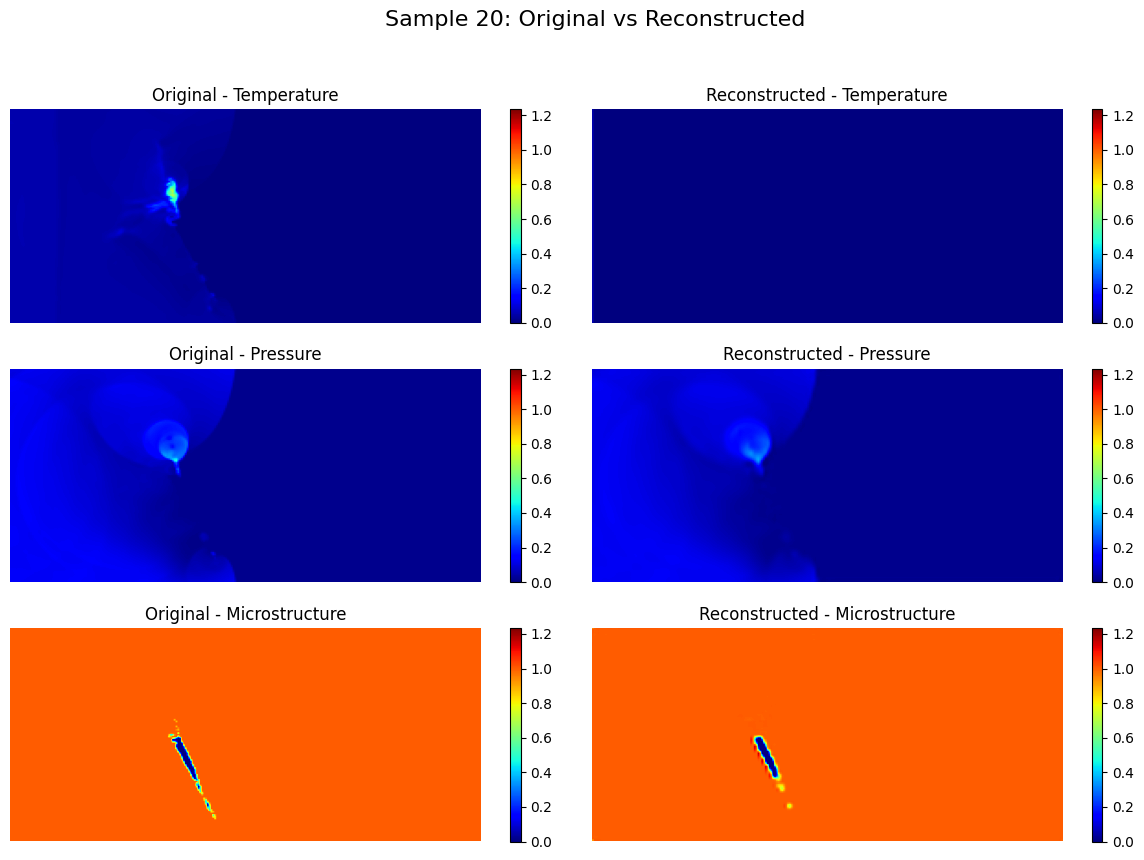

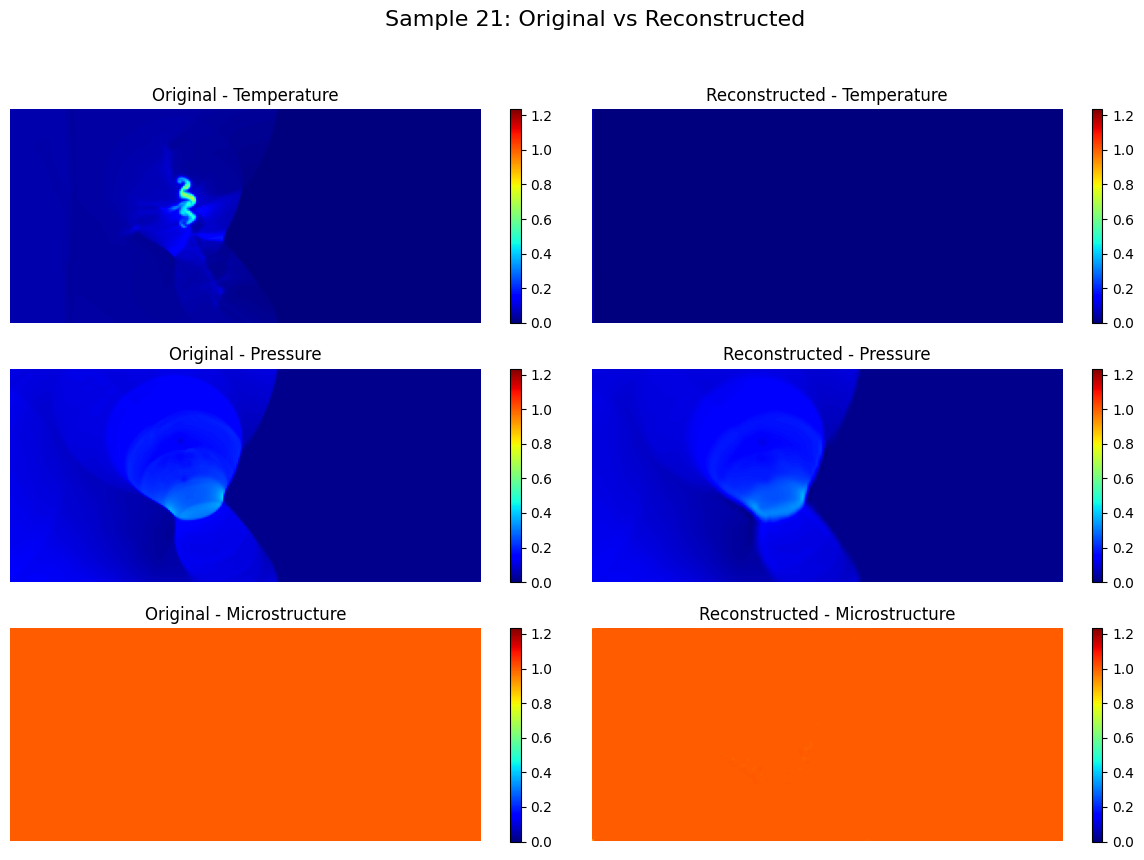

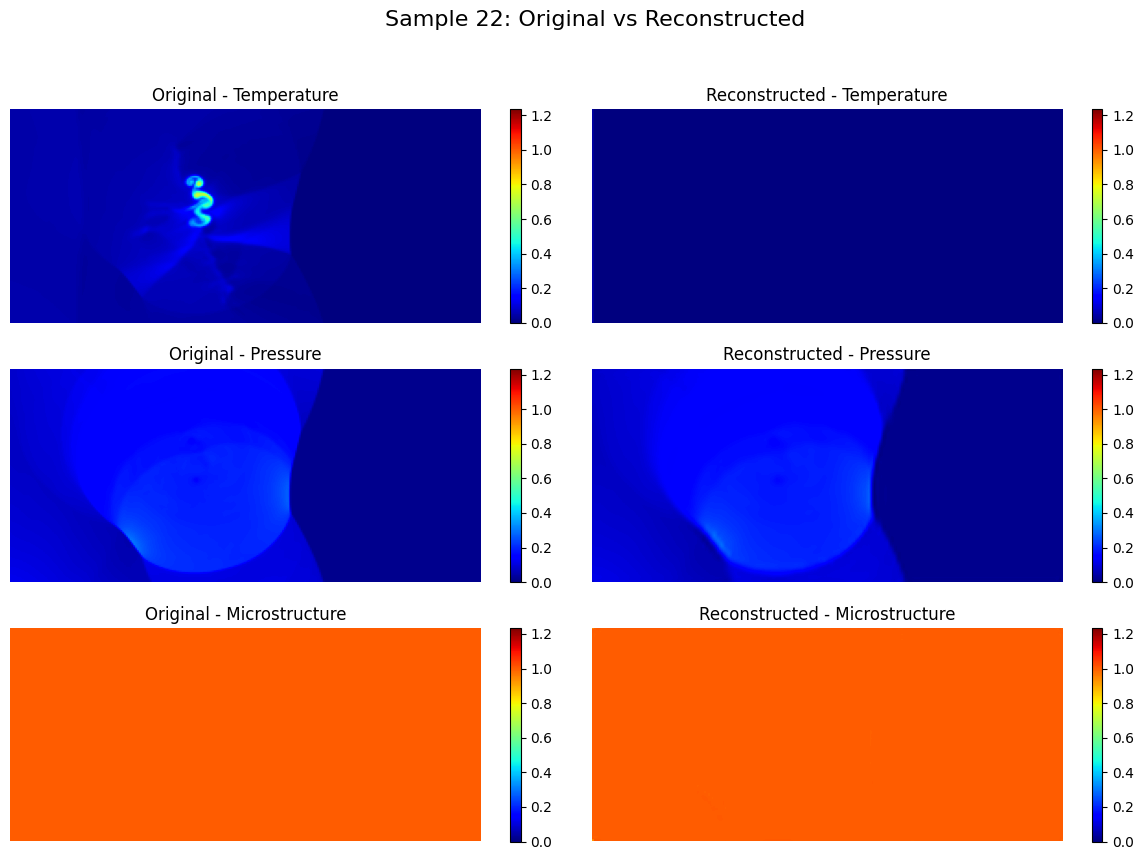

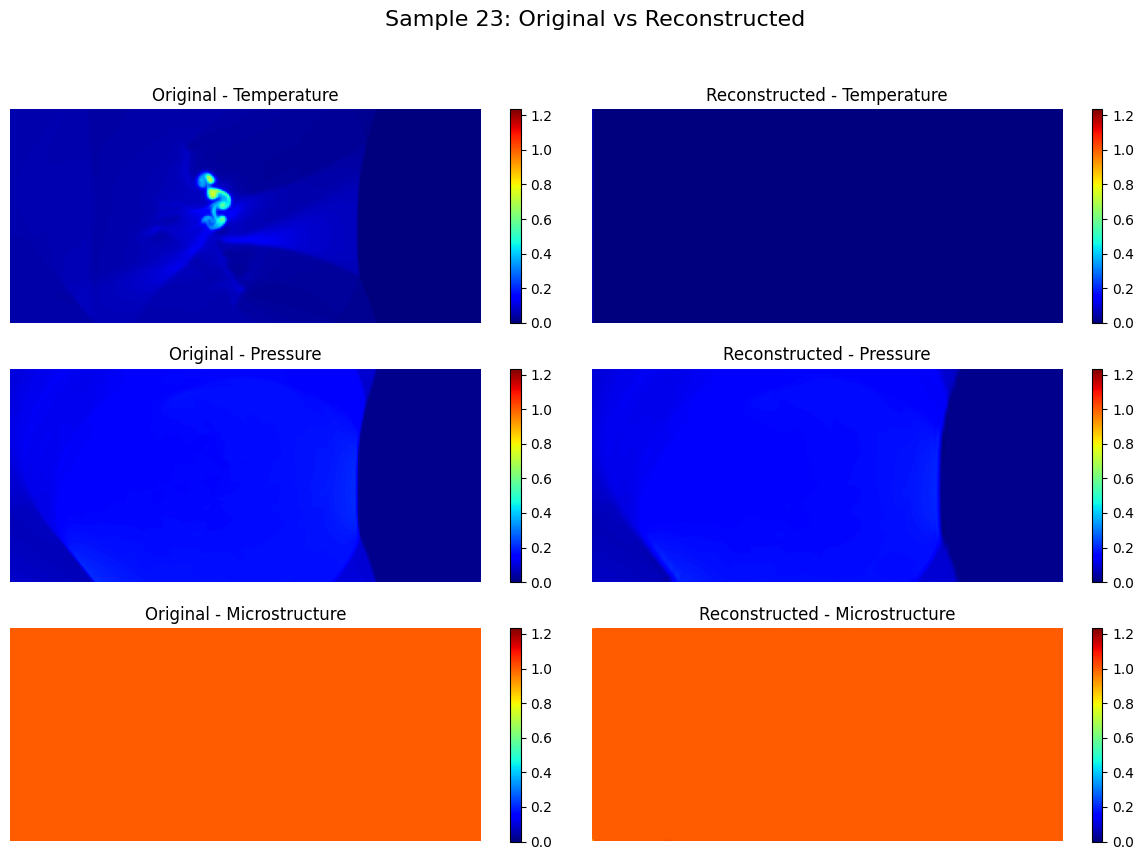

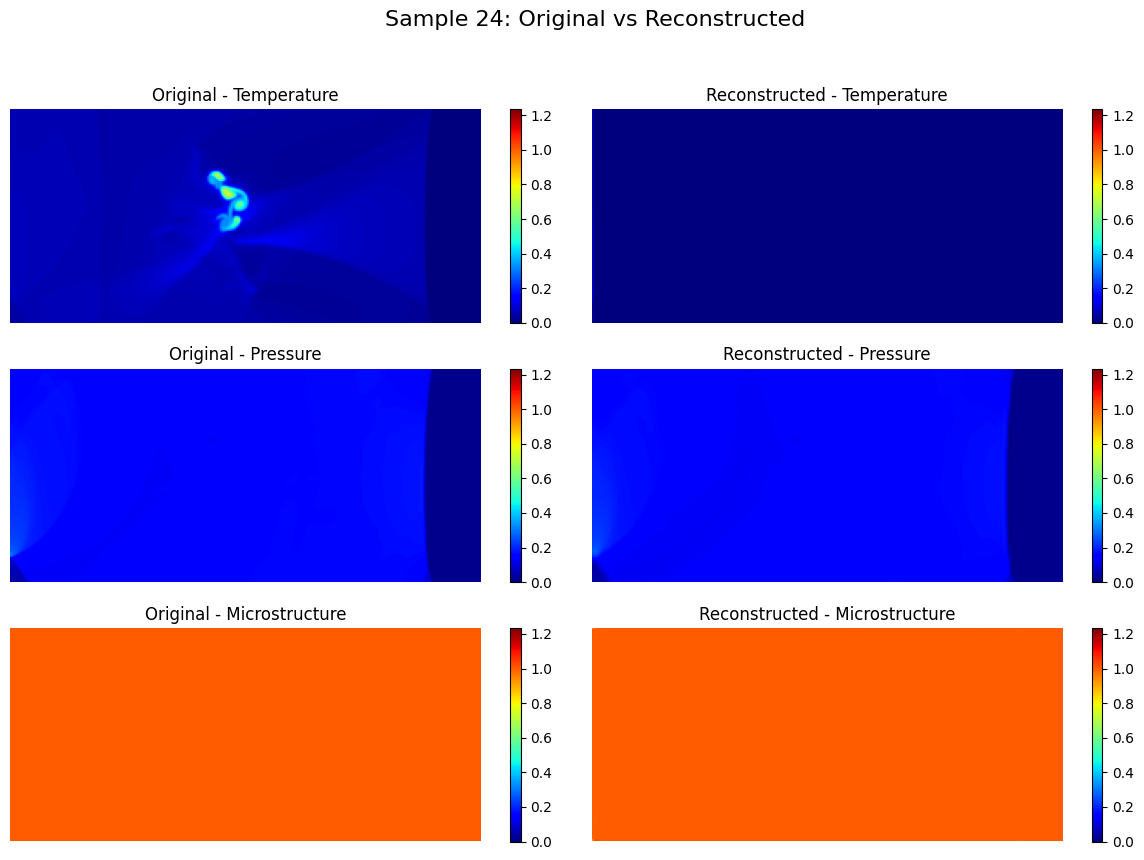

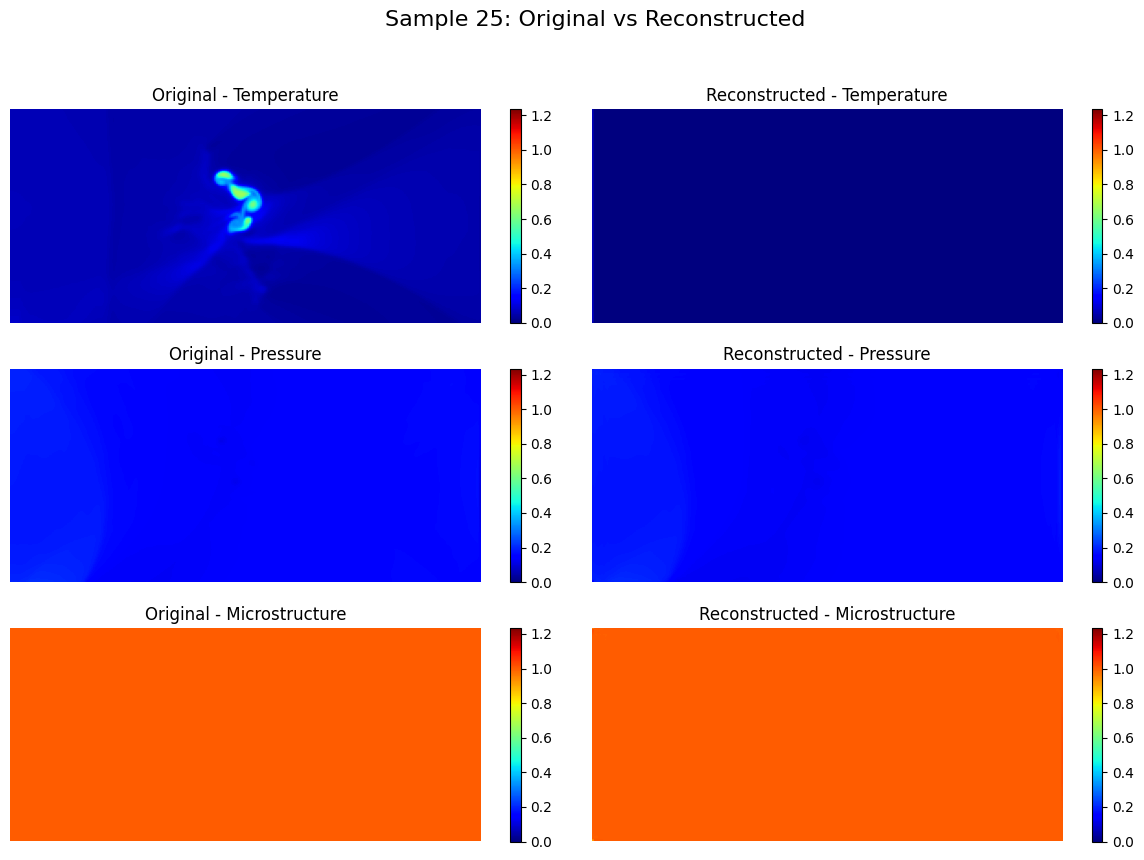

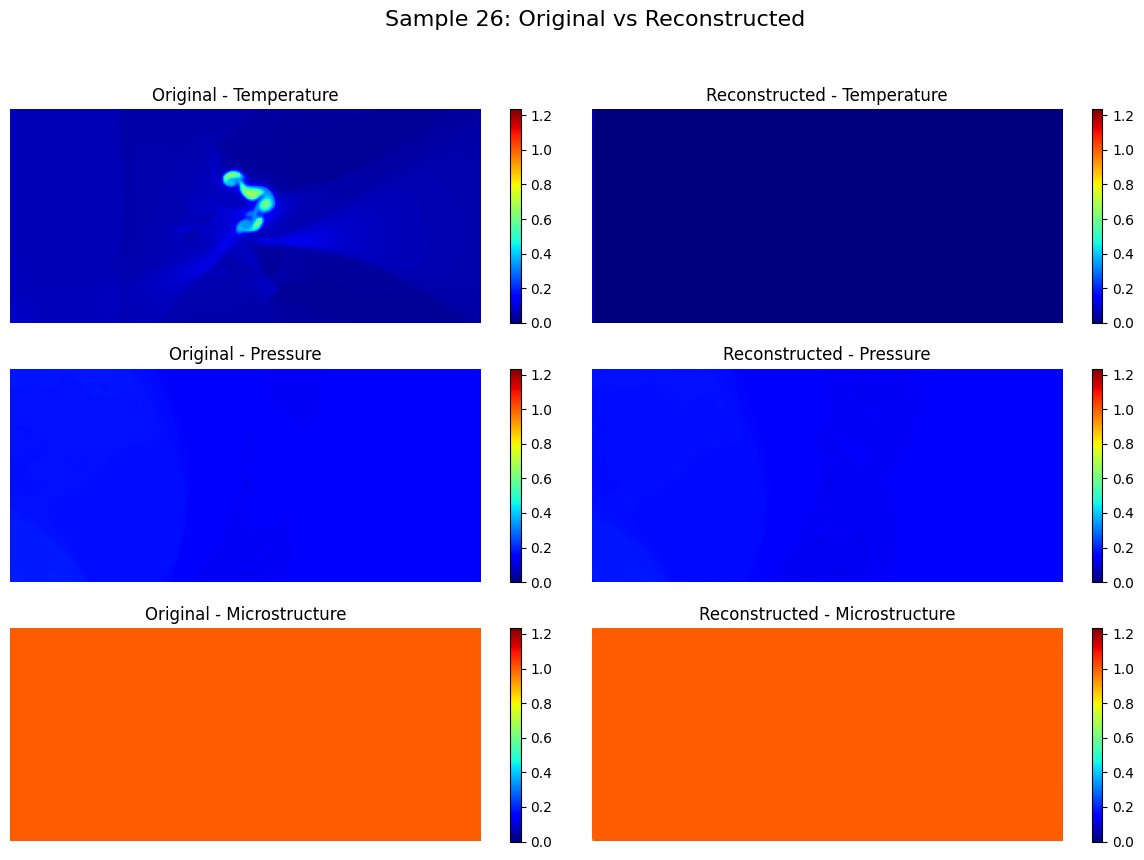

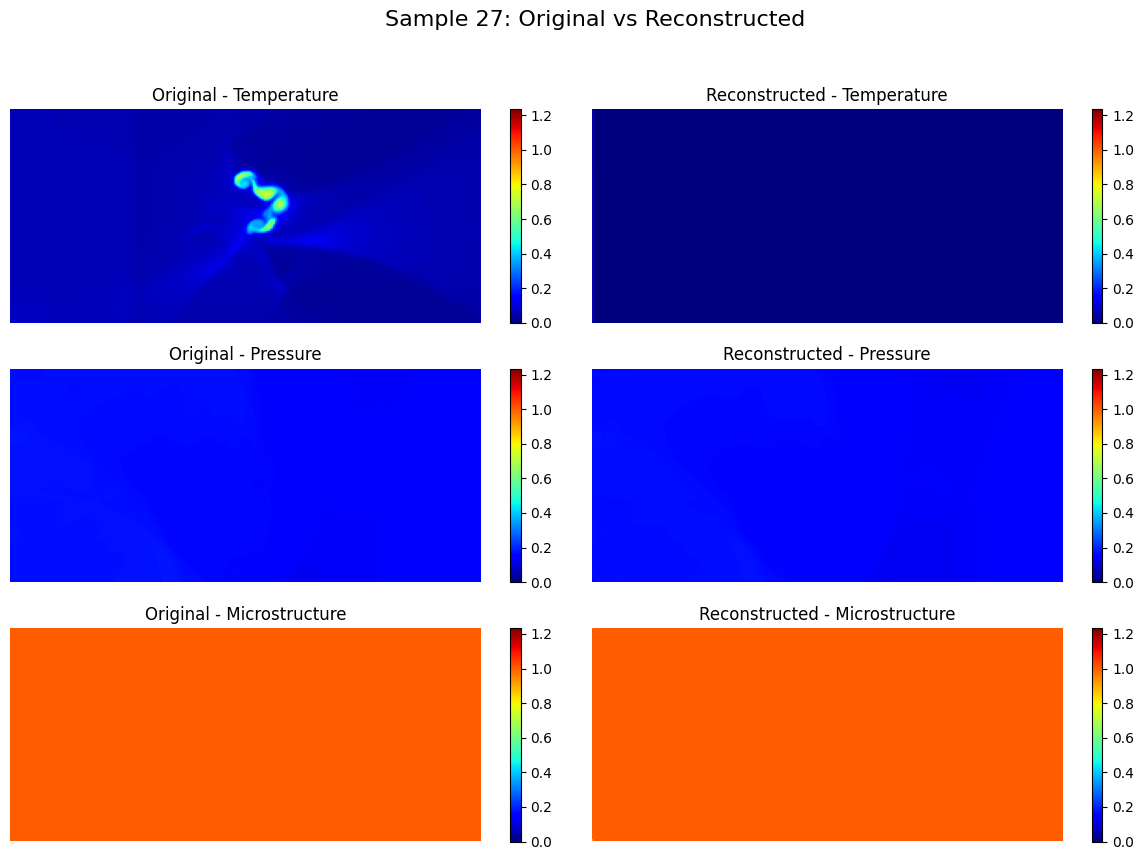

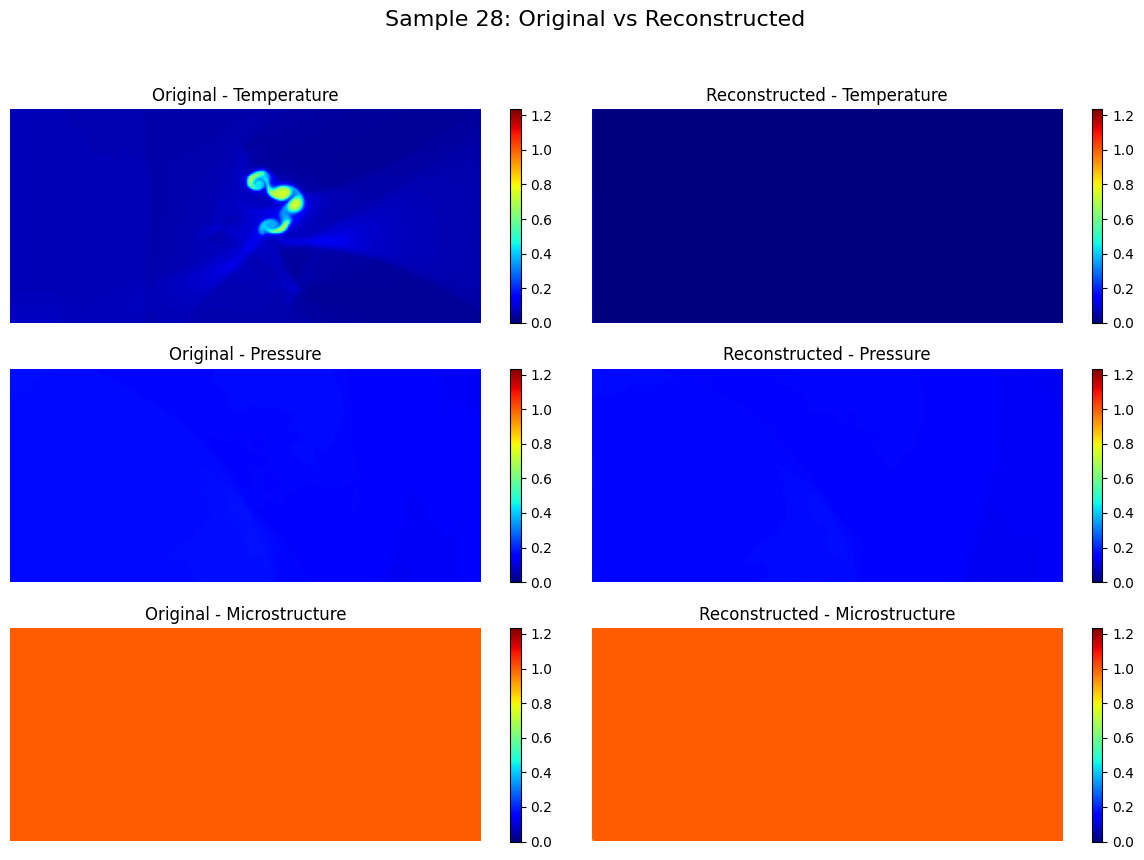

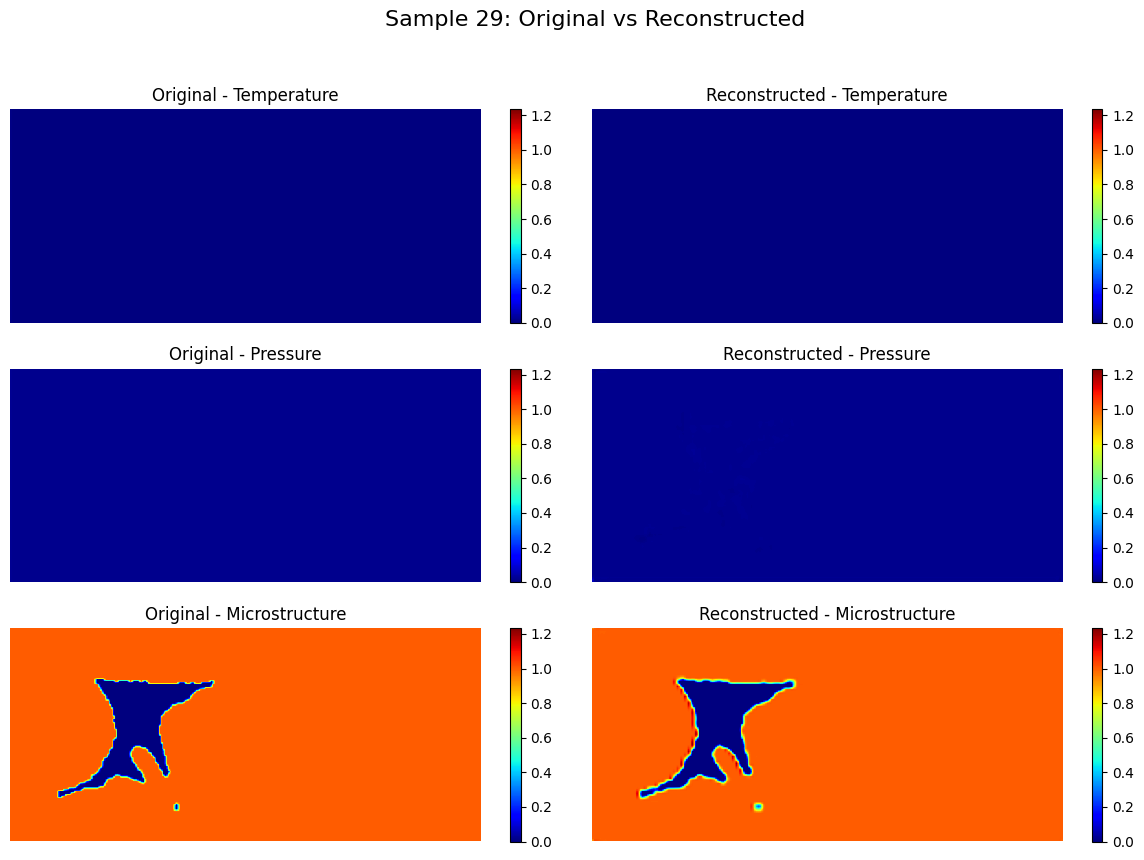

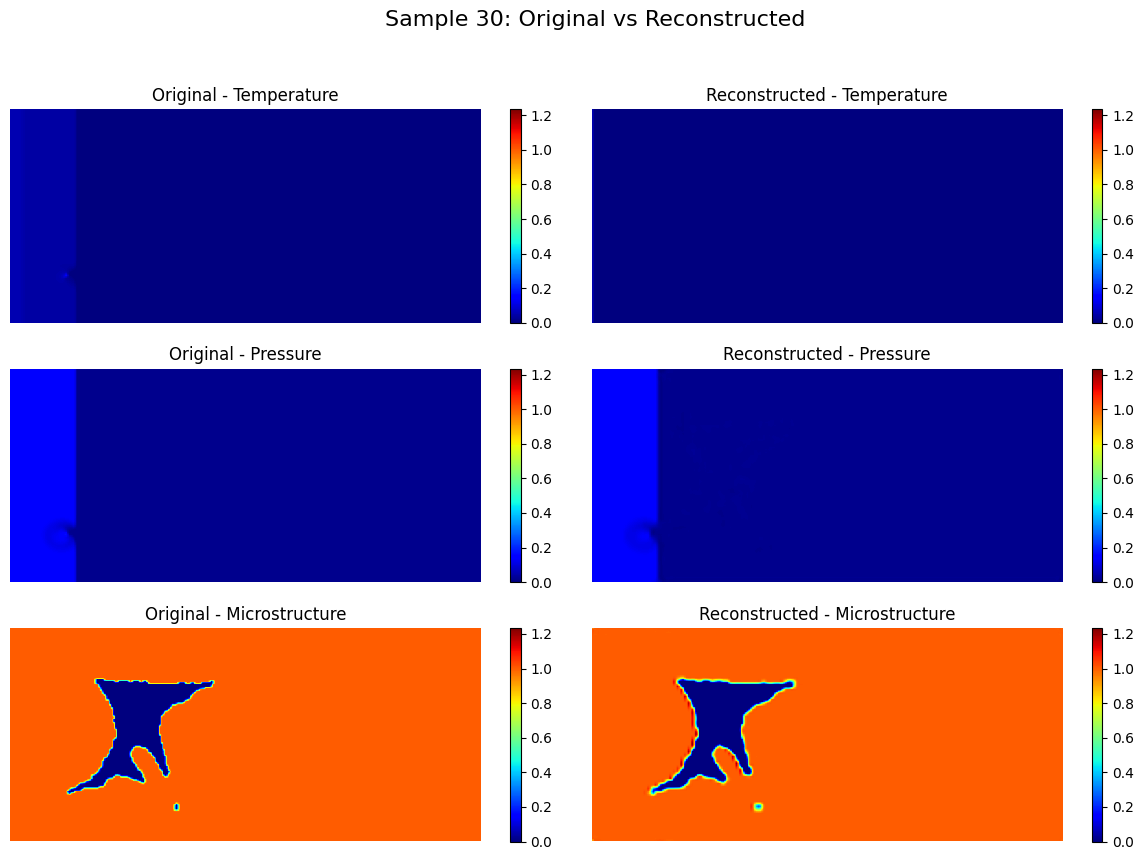

In [53]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = min(30, all_test_images.shape[0])  # Display up to 5 samples or fewer if dataset is smaller

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()


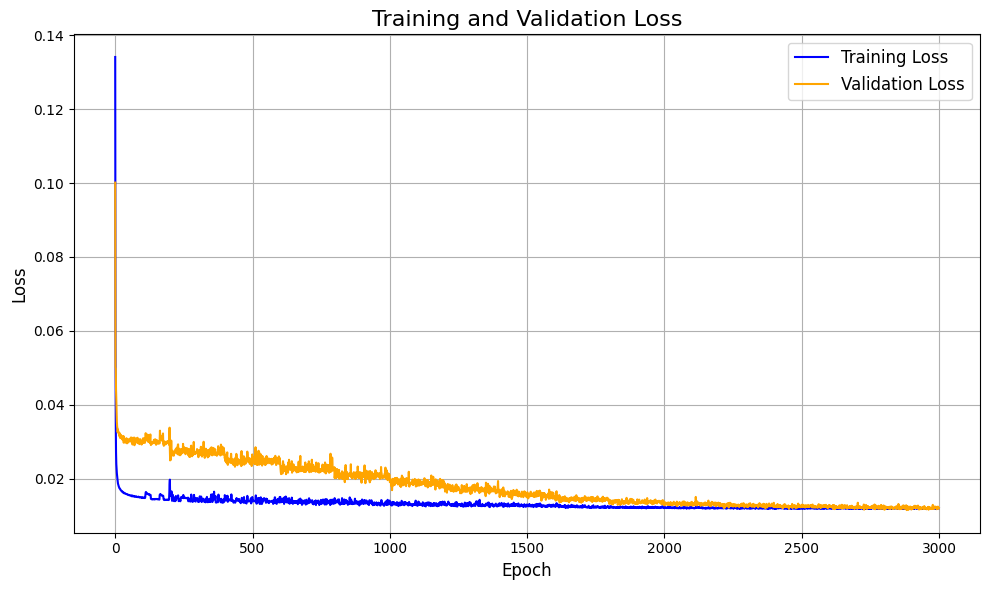

In [55]:
# Path to the JSON log file
log_file_path = "corrected_layers_3_8_latent_16_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


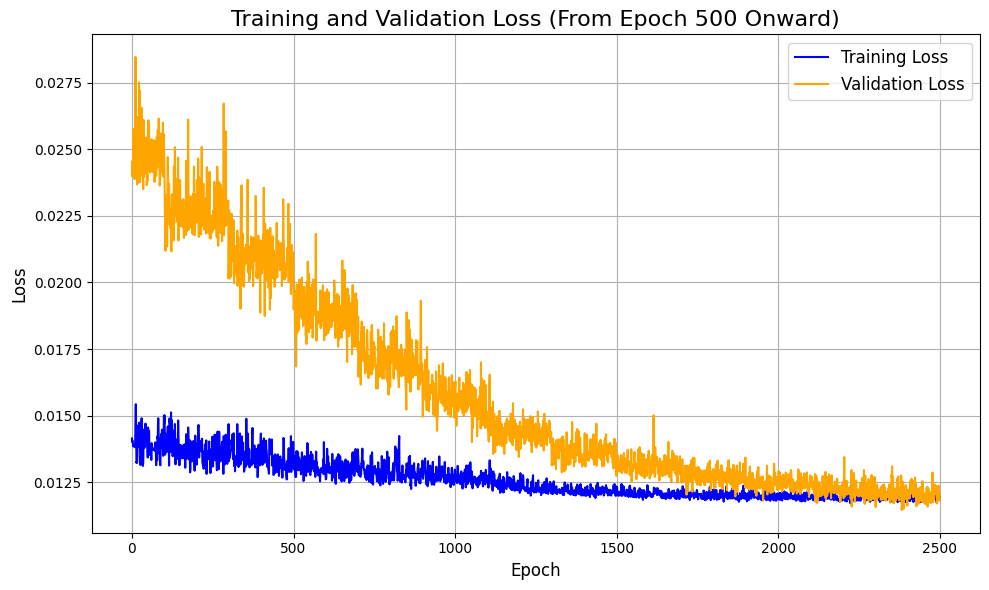

In [56]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 500

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss (From Epoch 500 Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
